In [1]:
#from pytube import YouTube
#from moviepy.editor import *

In [185]:
#from torch import nn

In [126]:
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import moviepy.editor as mp
import re

from src.helpers import *

In [261]:
import os
import glob
from PIL import Image
import pathlib
import csv
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import math 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [162]:
ll_path = '/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/linus_and_lucy.mp3'
%matplotlib inline
import seaborn
import IPython.display as ipd, sklearn
plt.rcParams['figure.figsize'] = (14, 5)

## Read in Three CSV files

In [4]:
dataset, class_labels, true_counts = data_to_df()


In [5]:
dataset.head()
class_labels.head()
#true_counts.head()

,index,mid,display_name
0,0,/m/09x0r,Speech
1,1,/m/05zppz,"Male speech, man speaking"
2,2,/m/02zsn,"Female speech, woman speaking"
3,3,/m/0ytgt,"Child speech, kid speaking"
4,4,/m/01h8n0,Conversation


## Clean data

In [309]:
dataset = clean_dataset(dataset, mlb)

dataset.drop(columns='positive_labels').head()

,YTID,start_seconds,end_seconds,recorded_labels
0,--PJHxphWEs,30.0,40.0,"[/m/09x0r, /t/dd00088]"
1,--ZhevVpy1s,50.0,60.0,[/m/012xff]
2,--aE2O5G5WE,0.0,10.0,"[/m/03fwl, /m/04rlf, /m/09x0r]"
3,--aO5cdqSAg,30.0,40.0,"[/t/dd00003, /t/dd00005]"
4,--aaILOrkII,200.0,210.0,"[/m/032s66, /m/073cg4]"


In [7]:
dataset.count()

YTID               22160
start_seconds      22160
end_seconds        22160
positive_labels    22160
recorded_labels    22160
dtype: int64

In [310]:
class_labels.head()

,index,mid,display_name
0,0,/m/09x0r,Speech
1,1,/m/05zppz,"Male speech, man speaking"
2,2,/m/02zsn,"Female speech, woman speaking"
3,3,/m/0ytgt,"Child speech, kid speaking"
4,4,/m/01h8n0,Conversation


### Clean true_counts data

There are a lot of labels that aren't very accurate. I only want to look at data with a certain percentage of labeling error. 

A lower ratio means heigher error

In [8]:
true_counts.sort_values('ratio', ascending=False).head(200)

,label_id,num_rated,num_true,sound,ratio
0,/m/09x0r,10,10,Speech,1.0
432,/m/0g6b5,10,10,Fireworks,1.0
191,/m/07y_7,10,10,"Violin, fiddle",1.0
426,/m/014zdl,10,10,Explosion,1.0
427,/m/032s66,10,10,"Gunshot, gunfire",1.0
...,...,...,...,...,...
430,/m/0_1c,10,8,Artillery fire,0.8
203,/m/0gy1t2s,10,8,Bicycle bell,0.8
126,/m/03vt0,10,8,Insect,0.8
199,/m/03m5k,10,8,Harp,0.8


In [9]:
true_counts = clean_true_counts(true_counts, class_labels)
true_counts.head()

,label_id,num_rated,num_true,sound,ratio
0,/m/09x0r,10,10,Speech,1.0
1,/m/05zppz,10,9,"Male speech, man speaking",0.9
2,/m/02zsn,10,10,"Female speech, woman speaking",1.0
3,/m/0ytgt,9,9,"Child speech, kid speaking",1.0
4,/m/01h8n0,10,8,Conversation,0.8


## Binarize entire df

Let's put every sound as it's own column, and if that sound appears in the video, we'll label it with a 1, else 0.

In [10]:
##remove all sounds (columns) where the ratio is under 0.8
df = get_most_accurate(dataset, true_counts, 0.8, mlb)

## remove all rows that are only 0's
df = reduce_rows(df)
df.head()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
0,--PJHxphWEs,30.0,40.0,"""/m/09x0r,/t/dd00088""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,--aE2O5G5WE,0.0,10.0,"""/m/03fwl,/m/04rlf,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,--aO5cdqSAg,30.0,40.0,"""/t/dd00003,/t/dd00005""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,--aaILOrkII,200.0,210.0,"""/m/032s66,/m/073cg4""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,--ekDLDTUXA,30.0,40.0,"""/m/015lz1,/m/07pws3f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### replace columns with sound names?

In [11]:
# for mid in class_labels['mid']:
#     if mid in df.columns:
#         df.columns[np.where(df.columns == mid)[0][0]] = class_labels['display_name'][class_labels['mid'] == mid]
# df.head()

In [12]:
np.where(df.columns == '/m/01280g')[0][0]
df.columns[4]

'/m/01280g'

### reindex df

In [13]:
df.index

Int64Index([    0,     2,     3,     4,     6,     7,     8,     9,    10,
               11,
            ...
            22148, 22150, 22151, 22152, 22153, 22154, 22155, 22156, 22157,
            22158],
           dtype='int64', length=18117)

In [14]:
df.index = range(len(df))
df.head()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
0,--PJHxphWEs,30.0,40.0,"""/m/09x0r,/t/dd00088""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,--aE2O5G5WE,0.0,10.0,"""/m/03fwl,/m/04rlf,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,--aO5cdqSAg,30.0,40.0,"""/t/dd00003,/t/dd00005""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,--aaILOrkII,200.0,210.0,"""/m/032s66,/m/073cg4""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,--ekDLDTUXA,30.0,40.0,"""/m/015lz1,/m/07pws3f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Make dataframes for each category to train

In [15]:
music_df = df[df['/m/04rlf'] == 1]
music_df.head()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
1,--aE2O5G5WE,0.0,10.0,"""/m/03fwl,/m/04rlf,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0DLPzsiXXE,30.0,40.0,"""/m/04rlf,/m/07qwdck""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-0FHUc78Gqo,30.0,40.0,"""/m/02w4v,/m/04rlf""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,-0SdAVK79lg,30.0,40.0,"""/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rl...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,-0mG4W5Hlq8,270.0,280.0,"""/m/04rlf,/m/05fw6t,/m/07r4k75,/m/09x0r,/m/0ytgt""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
speech_df = df[df['/m/09x0r'] == 1]
speech_df.head()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
0,--PJHxphWEs,30.0,40.0,"""/m/09x0r,/t/dd00088""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,--aE2O5G5WE,0.0,10.0,"""/m/03fwl,/m/04rlf,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,-0mG4W5Hlq8,270.0,280.0,"""/m/04rlf,/m/05fw6t,/m/07r4k75,/m/09x0r,/m/0ytgt""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,-30H9V1IKps,6.0,16.0,"""/m/07yv9,/m/09x0r,/m/0gvgw0""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,-3IGxVTJvgI,30.0,40.0,"""/m/06bz3,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
water_df = df[(df['/m/0838f'] == 1)]
water_df.head()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
6,-0DdlOuIFUI,50.0,60.0,"""/m/0130jx,/m/02jz0l,/m/0838f""",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32,-5GhUbDLYkQ,16.0,26.0,"""/m/0130jx,/m/02jz0l,/m/0838f""",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58,-8_HpHg6nCw,30.0,40.0,"""/m/07ptzwd,/m/0838f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,-PFO-nCfRq0,0.0,9.0,"""/m/01jt3m,/m/0838f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217,-YxGyNHMasQ,240.0,250.0,"""/m/0130jx,/m/02jz0l,/m/0838f""",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
singing_df = df[df['/m/015lz1'] == 1]
singing_df.head()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
4,--ekDLDTUXA,30.0,40.0,"""/m/015lz1,/m/07pws3f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,-1iKLvsRBbE,80.0,90.0,"""/m/015lz1,/m/07pws3f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,-4hZyOdm7EI,200.0,210.0,"""/m/015lz1,/m/015vgc""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,-693sNKI3iM,30.0,40.0,"""/m/015lz1,/m/01swy6,/m/04rlf""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,-ETHxO8vrAg,30.0,40.0,"""/m/015lz1,/m/04rlf,/t/dd00004""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA Let's look at the most common sounds reported

In [19]:
len(df)

18117

In [20]:
sums = np.array(df.sum())

In [21]:
i = 0
for column in df.columns:
    if i > 3:
        print(sum(df[column]), column)
    i += 1    
    

61 /m/01280g
63 /m/012f08
60 /m/012ndj
66 /m/0130jx
61 /m/0140xf
60 /m/0145m
60 /m/014yck
63 /m/014zdl
60 /m/0150b9
62 /m/0155w
517 /m/015lz1
172 /m/015p6
61 /m/015vgc
60 /m/015y_n
60 /m/0164x2
62 /m/016cjb
60 /m/018j2
60 /m/0192l
60 /m/0195fx
242 /m/019jd
60 /m/01b82r
60 /m/01b_21
61 /m/01c194
60 /m/01d3sd
183 /m/01g50p
60 /m/01h3n
60 /m/01h82_
60 /m/01h8n0
61 /m/01hgjl
60 /m/01hnzm
60 /m/01hsr_
112 /m/01j3sz
60 /m/01j4z9
60 /m/01jt3m
231 /m/01kcd
60 /m/01lyv
60 /m/01m2v
60 /m/01m4t
63 /m/01p970
64 /m/01qbl
60 /m/01v1d8
61 /m/01w250
63 /m/01wy6
60 /m/01x3z
62 /m/01xq0k1
67 /m/01xqw
122 /m/01yrx
60 /m/01z5f
60 /m/01z7dr
128 /m/020bb7
60 /m/024dl
60 /m/025_jnm
202 /m/025rv6n
60 /m/025td0t
60 /m/0261r1
189 /m/026t6
64 /m/026z9
60 /m/0283d
63 /m/0284vy3
64 /m/028ght
64 /m/028sqc
60 /m/028v0c
60 /m/02_nn
60 /m/02bk07
60 /m/02bxd
61 /m/02cjck
60 /m/02cz_7
62 /m/02fs_r
61 /m/02fsn
60 /m/02g901
94 /m/02hnl
87 /m/02jz0l
109 /m/02lkt
186 /m/02mk9
66 /m/02mscn
60 /m/02p0sh1
60 /m/02p3nc
60 /m/02

### Max occurring: 
517 /m/015lz1
172 /m/015p6
242 /m/019jd
183 /m/01g50p
112 /m/01j3sz
231 /m/01kcd
122 /m/01yrx
128 /m/020bb7
202 /m/025rv6n
189 /m/026t6
109 /m/02lkt
186 /m/02mk9
178 /m/032s66
350 /m/0342h
141 /m/03j1ly
207 /m/03kmc9
168 /m/03m9d0z
171 /m/03vt0
6244 /m/04rlf    music
532 /m/04szw
142 /m/05148p4
860 /m/07yv9
286 /m/0838f    water
262 /m/085jw
5735 /m/09x0r   speech
273 /m/0bt9lr
124 /m/0ch8v
302 /m/0fx80y
734 /m/0jbk
296 /m/0k4j
109 /m/0k5j
115 /m/0l14_3
263 /m/0l14md
154 /m/0ytgt
118 /t/dd00077
143 /t/dd00092
764 /t/dd00125
256 /t/dd00128    outside - urban/manmade
255 /t/dd00129    Outside - rural/natural

In [49]:
df[df['YTID'] == '0M8SMwwe0Ow']

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
500,0M8SMwwe0Ow,30.0,40.0,"""/m/06bz3,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Downloading the youtube audio data:

### i might need to break up df into a smaller section due to time and space
What I'm thinking:
- iterate through dataset
- download audio file for each video, to mp3, extract meaningful features, append to new dataframe
- if error, remove row from dataset
- clean up after each iteration

# First Chunk

In [23]:
df[df['YTID'] == '1TGd0asihZw']

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
912,1TGd0asihZw,260.0,270.0,"""/m/04rlf,/m/05r5wn""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
df[df['YTID'] == '-m1eF1B0Qlk']

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
286,-m1eF1B0Qlk,50.0,60.0,"""/m/02rr_,/m/0342h,/m/04rlf,/m/07m2kt,/m/0g12c5""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [221]:

## download one video
video = '-gsDBuHwqbM'
path = "/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp4"
filename = download_video(video, path)
mp3, mp4 = to_mp3(path, filename)
start = 10



IndexError: list index out of range

In [92]:
#iter_two = df[df.index > 1514]
#dataset_iter_two = dataset[dataset.index > 1514]
path = "/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp4"
header = make_feature_file()
num_downloaded = 0
for video in df['YTID']:
    try:
    
        ##download youtube audio
        filename = download_video(str(video), path)
        ##convert to mp3 file
        mp3, mp4 = to_mp3(path, filename)
        ##get starting time for video
        start = int(df['start_seconds'][df['YTID'] == video])
        ##turn mp3 into spectrogram and extract features
        
        features = get_features(mp3, start)
        ##write features to dataframe
        write_to_file(features)

 #       os.remove(mp3)
        
        
        num_downloaded += 1
        print(num_downloaded)
        
    
    

    except Exception:
        #remove row from initial dataset with invalid youtube id
        
        df = df[df['YTID'] != video]
#         try: 
#             os.remove(mp3)
#         except:
#             pass
#         try:
#             os.remove(mp4)
#         except:
#             pass


    cleanup()

chunk:   7%|▋         | 154/2262 [00:00<00:01, 1538.40it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/--PJHxphWEs.mp3


MoviePy - Done.
1


chunk:  42%|████▏     | 93/222 [00:00<00:00, 929.88it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/--aE2O5G5WE.mp3


MoviePy - Done.
2


chunk:   2%|▏         | 86/4603 [00:00<00:05, 842.09it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/--aaILOrkII.mp3


MoviePy - Done.
3


chunk:   2%|▏         | 98/4836 [00:00<00:04, 961.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/--ekDLDTUXA.mp3


MoviePy - Done.
4


chunk:   5%|▍         | 94/1986 [00:00<00:02, 918.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-0DLPzsiXXE.mp3


MoviePy - Done.
5


chunk:   4%|▍         | 138/3669 [00:00<00:02, 1370.34it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-0DdlOuIFUI.mp3


MoviePy - Done.
6


chunk:   3%|▎         | 136/4102 [00:00<00:02, 1353.98it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-0O3e95y4gE.mp3


MoviePy - Done.
7


chunk:   0%|          | 70/23107 [00:00<00:33, 681.25it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-0SdAVK79lg.mp3


MoviePy - Done.
8


chunk:   2%|▏         | 74/2968 [00:00<00:03, 735.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-11LhdJgBb8.mp3


MoviePy - Done.
9


chunk:   2%|▏         | 154/6277 [00:00<00:03, 1539.72it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-1LrH01Ei1w.mp3


MoviePy - Done.
10


chunk:   2%|▏         | 83/4011 [00:00<00:04, 827.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-1TLtjPtnms.mp3


MoviePy - Done.
11


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-275_wTLm-4.mp3
MoviePy - Done.


chunk:  15%|█▌        | 102/678 [00:00<00:00, 1016.24it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-2PDE7hUArE.mp3


MoviePy - Done.
12


chunk:  10%|▉         | 102/1036 [00:00<00:00, 1006.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-2X03mO3T_U.mp3


MoviePy - Done.
13


chunk:   5%|▍         | 103/2285 [00:00<00:02, 1019.89it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-2hQKCE-oTI.mp3


MoviePy - Done.
14


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-30H9V1IKps.mp3
MoviePy - Done.


chunk:   5%|▍         | 103/2275 [00:00<00:02, 1000.31it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-38Qgsbh7NQ.mp3


MoviePy - Done.
15


chunk:   1%|          | 140/20229 [00:00<00:14, 1394.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-3HYdaJyF4U.mp3


MoviePy - Done.
16


chunk:   2%|▏         | 90/3686 [00:00<00:04, 891.98it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-3IGxVTJvgI.mp3


MoviePy - Done.
17


chunk:  10%|█         | 180/1726 [00:00<00:00, 1791.17it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-3hKkjKmIGE.mp3


MoviePy - Done.
18


chunk:   1%|▏         | 116/8228 [00:00<00:07, 1121.12it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-3pPrlCm6gg.mp3


MoviePy - Done.
19


chunk:   2%|▏         | 84/4312 [00:00<00:05, 829.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-4NLarMj4xU.mp3


MoviePy - Done.
20


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-4RWqM0UCCY.mp3
MoviePy - Done.


21


chunk:   1%|▏         | 126/9026 [00:00<00:07, 1238.99it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-4hZyOdm7EI.mp3


MoviePy - Done.
22


chunk:   1%|▏         | 103/7254 [00:00<00:07, 1017.01it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-5-vmt2iKT0.mp3


MoviePy - Done.
23


chunk:  42%|████▏     | 145/343 [00:00<00:00, 1449.71it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-5GhUbDLYkQ.mp3


MoviePy - Done.


chunk:   5%|▍         | 104/2310 [00:00<00:02, 1038.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-5Jlimvsuwo.mp3


MoviePy - Done.
24


chunk:   1%|          | 132/18134 [00:00<00:13, 1318.68it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-5S70zOSw30.mp3


MoviePy - Done.
25


chunk:   2%|▏         | 82/5285 [00:00<00:06, 802.25it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-5f6hjZf9Yw.mp3


MoviePy - Done.
26


chunk:   2%|▏         | 116/6522 [00:00<00:05, 1158.42it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-5xOcMJpTUk.mp3


MoviePy - Done.
27


chunk:   2%|▏         | 170/11100 [00:00<00:06, 1693.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-60XojQWWoc.mp3


MoviePy - Done.
28


chunk:   2%|▏         | 110/5067 [00:00<00:04, 1087.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-64xnyOswXA.mp3


MoviePy - Done.
29


chunk:   4%|▍         | 204/4862 [00:00<00:02, 2037.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-693sNKI3iM.mp3


MoviePy - Done.
30


chunk:   0%|          | 116/54187 [00:00<00:46, 1152.14it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-6QGvxvaTkI.mp3


MoviePy - Done.
31


chunk:   1%|▏         | 167/13236 [00:00<00:07, 1664.71it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-6RN8skIHU4.mp3


MoviePy - Done.
32


chunk:   1%|          | 98/13075 [00:00<00:13, 969.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-6gC_nlUBfA.mp3


MoviePy - Done.
33


chunk:   4%|▍         | 90/2219 [00:00<00:02, 898.71it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-6krAYK2LLo.mp3


MoviePy - Done.
34


chunk:  21%|██        | 141/664 [00:00<00:00, 1404.94it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-6x2PtSRfJU.mp3


MoviePy - Done.
35


chunk:   2%|▏         | 81/5267 [00:00<00:06, 807.71it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-70MzkgSsHQ.mp3


MoviePy - Done.
36


chunk:   4%|▍         | 122/2961 [00:00<00:02, 1218.40it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-75IwDlkzDQ.mp3


MoviePy - Done.
37


chunk:   1%|          | 94/9307 [00:00<00:09, 929.08it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-7J4109yM7w.mp3


MoviePy - Done.
38


chunk:   1%|          | 103/10159 [00:00<00:09, 1022.58it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-7QVE8o9uk4.mp3


MoviePy - Done.
39


chunk:   6%|▌         | 103/1731 [00:00<00:01, 1021.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-7wUQP6G5EQ.mp3


MoviePy - Done.
40


chunk:   1%|          | 126/19669 [00:00<00:15, 1236.37it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-7ye24UFRng.mp3


MoviePy - Done.
41


chunk:  16%|█▌        | 184/1138 [00:00<00:00, 1823.21it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-8CrCItCO24.mp3


MoviePy - Done.
42


chunk:   3%|▎         | 154/5105 [00:00<00:03, 1506.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-8H4GKg-mYQ.mp3


MoviePy - Done.
43


chunk:   2%|▏         | 111/4450 [00:00<00:03, 1106.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-8S_tLKfeJg.mp3


MoviePy - Done.
44


chunk:  13%|█▎        | 188/1480 [00:00<00:00, 1868.04it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-8_HpHg6nCw.mp3


MoviePy - Done.
45


chunk:   9%|▉         | 196/2132 [00:00<00:00, 1950.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-8fQePz4FcE.mp3


MoviePy - Done.
46


chunk:   1%|          | 107/9467 [00:00<00:08, 1067.58it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-8n2NqDFRko.mp3


MoviePy - Done.
47


chunk:   3%|▎         | 135/4880 [00:00<00:03, 1349.13it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-8wQV7VJnmM.mp3


MoviePy - Done.
48


chunk:  16%|█▌        | 126/776 [00:00<00:00, 1236.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-99daJhXYJY.mp3


MoviePy - Done.
49


chunk:   2%|▏         | 160/8877 [00:00<00:05, 1597.56it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-9ME9qMgkeY.mp3


MoviePy - Done.
50


chunk:   1%|▏         | 120/8345 [00:00<00:07, 1168.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-9Nl3LZBCOo.mp3


MoviePy - Done.
51


chunk:  29%|██▉       | 152/520 [00:00<00:00, 1517.37it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-9c1c8G_WO8.mp3


MoviePy - Done.


chunk:   6%|▌         | 172/2803 [00:00<00:01, 1702.26it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-AIrHVeCgtM.mp3


MoviePy - Done.
52


chunk:   5%|▍         | 148/3191 [00:00<00:02, 1449.05it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-ASYwidRD7M.mp3


MoviePy - Done.
53


chunk:   8%|▊         | 295/3911 [00:00<00:01, 2949.78it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-AgbNy9f2sg.mp3


MoviePy - Done.
54


chunk:   2%|▏         | 180/11126 [00:00<00:06, 1798.09it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-Ar7D-GARhI.mp3


MoviePy - Done.
55


chunk:  15%|█▍        | 98/673 [00:00<00:00, 976.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-AswFDuOptQ.mp3


MoviePy - Done.
56


chunk:   4%|▍         | 200/4639 [00:00<00:02, 1992.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-BcwR0CSZ4w.mp3


MoviePy - Done.
57


chunk:   1%|          | 113/19853 [00:00<00:17, 1128.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-BqpAyCLh7U.mp3


MoviePy - Done.
58


chunk:  21%|██▏       | 188/876 [00:00<00:00, 1867.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-By_0iIghuE.mp3


MoviePy - Done.
59


chunk:   4%|▍         | 193/4411 [00:00<00:02, 1927.85it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-C5dEU4zpJg.mp3


MoviePy - Done.
60


chunk:   1%|          | 132/12247 [00:00<00:09, 1298.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-CIxoobEubQ.mp3


MoviePy - Done.
61


chunk:   6%|▌         | 205/3719 [00:00<00:01, 2014.55it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-CUp_Tmg2Y0.mp3


MoviePy - Done.
62


chunk:   1%|          | 128/20310 [00:00<00:15, 1261.66it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-CgdUiJaNdU.mp3


MoviePy - Done.
63


chunk:   3%|▎         | 162/5163 [00:00<00:03, 1617.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-CniGkDLq-Y.mp3


MoviePy - Done.
64


chunk:  15%|█▌        | 168/1120 [00:00<00:00, 1679.90it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-DBcp6YGi6k.mp3


MoviePy - Done.
65


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-DLL8LaKq-c.mp3


MoviePy - Done.


chunk:  25%|██▍       | 205/835 [00:00<00:00, 2037.08it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-DNkAalo7og.mp3


MoviePy - Done.
66


chunk:   1%|          | 124/10986 [00:00<00:08, 1224.40it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-DWRAxaH_RY.mp3


MoviePy - Done.
67


chunk:   0%|          | 116/29157 [00:00<00:25, 1133.34it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-D_ljLTbCK0.mp3


MoviePy - Done.
68


chunk:   1%|▏         | 102/7115 [00:00<00:06, 1016.61it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-DeAdhYKbGE.mp3


MoviePy - Done.
69


chunk:   9%|▊         | 171/1990 [00:00<00:01, 1705.36it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-Dj2PfPmynQ.mp3


MoviePy - Done.
70


chunk:   2%|▏         | 120/6112 [00:00<00:05, 1191.24it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-Dl-VzBPd9E.mp3


MoviePy - Done.
71


chunk:   1%|          | 144/13584 [00:00<00:09, 1434.98it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-Dtir74TiUM.mp3


MoviePy - Done.
72


chunk:   1%|          | 159/14391 [00:00<00:08, 1588.81it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-DvxsHG1tuo.mp3


MoviePy - Done.
73


chunk:  34%|███▍      | 164/479 [00:00<00:00, 1634.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-E013cWxoMo.mp3


MoviePy - Done.
74


chunk:   8%|▊         | 134/1607 [00:00<00:01, 1337.42it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-ECK_BisOLM.mp3


MoviePy - Done.
75


chunk:  15%|█▍        | 161/1100 [00:00<00:00, 1609.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-EDGR1davAc.mp3


MoviePy - Done.
76


chunk:   2%|▏         | 106/4412 [00:00<00:04, 1057.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-EDhb2m8qhk.mp3


MoviePy - Done.
77


chunk:   3%|▎         | 220/6725 [00:00<00:02, 2187.18it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-EFS2mihxs0.mp3


MoviePy - Done.
78


chunk:   3%|▎         | 98/3069 [00:00<00:03, 972.46it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-En5nC5Tka4.mp3


MoviePy - Done.
79


chunk:   1%|          | 70/6469 [00:00<00:09, 664.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-FEPOSP7ay0.mp3


MoviePy - Done.
80


chunk:   1%|          | 74/6739 [00:00<00:09, 732.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-FFx68qSAuY.mp3


MoviePy - Done.
81


chunk:   0%|          | 86/23943 [00:00<00:27, 856.06it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-FT5MbWPCzg.mp3


MoviePy - Done.
82


chunk:   2%|▏         | 130/5961 [00:00<00:04, 1291.05it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-FlvaZQOr2I.mp3


MoviePy - Done.
83


chunk:   2%|▏         | 191/9148 [00:00<00:04, 1907.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-GDC7PuqdOM.mp3


MoviePy - Done.
84


chunk:  10%|▉         | 103/1067 [00:00<00:00, 1014.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-GI5PbO6j50.mp3


MoviePy - Done.
85


chunk:   3%|▎         | 115/3427 [00:00<00:02, 1149.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-GREE8GdRrc.mp3


MoviePy - Done.
86


chunk:   1%|          | 159/12934 [00:00<00:08, 1588.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-G_hnfp4a0M.mp3


MoviePy - Done.
87


chunk:   2%|▏         | 123/7996 [00:00<00:06, 1227.67it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-GaHBgRGi4s.mp3


MoviePy - Done.
88


chunk:   5%|▌         | 166/3226 [00:00<00:01, 1655.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-GbQWmFzVdY.mp3


MoviePy - Done.
89


chunk:   1%|          | 78/10790 [00:00<00:13, 768.96it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-GiRtQZlnbw.mp3


MoviePy - Done.
90


chunk:   3%|▎         | 162/5433 [00:00<00:03, 1619.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-H5kC4WsuI8.mp3


MoviePy - Done.
91


chunk:   1%|          | 94/13673 [00:00<00:14, 919.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-HN5kqCKpEA.mp3


MoviePy - Done.
92


chunk:   1%|          | 120/12843 [00:00<00:10, 1198.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-HlS6jz-f0I.mp3


MoviePy - Done.
93


chunk:   2%|▏         | 103/5954 [00:00<00:05, 1017.56it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-HnNrGtKXp4.mp3


MoviePy - Done.
94


chunk:   5%|▌         | 175/3219 [00:00<00:01, 1747.22it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-IWlQN6cfe4.mp3


MoviePy - Done.
95


chunk:   0%|          | 102/40761 [00:00<00:40, 997.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-IZsyroG6yo.mp3


MoviePy - Done.
96


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-ItCGHv_9Gs.mp3
MoviePy - Done.


chunk:   4%|▍         | 168/4015 [00:00<00:02, 1678.77it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-J0H5ah1G7A.mp3


MoviePy - Done.
97


chunk:   1%|          | 116/19673 [00:00<00:16, 1151.44it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-JBvPwxaVVg.mp3


MoviePy - Done.
98


chunk:   1%|          | 112/12972 [00:00<00:11, 1116.36it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-JKLmqDk9p8.mp3


MoviePy - Done.
99


chunk:   1%|          | 178/17284 [00:00<00:09, 1779.65it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-JOKwS64mRU.mp3


MoviePy - Done.
100


chunk:   4%|▍         | 134/3537 [00:00<00:02, 1331.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-Jam3cjbeFQ.mp3


MoviePy - Done.
101


chunk:   2%|▏         | 150/6560 [00:00<00:04, 1470.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-JbPonixXS4.mp3


MoviePy - Done.
102


chunk:   1%|          | 136/11666 [00:00<00:08, 1359.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-JfpacjZWyw.mp3


MoviePy - Done.
103


chunk:   1%|▏         | 122/8759 [00:00<00:07, 1216.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-JuVh6islEI.mp3


MoviePy - Done.
104


chunk:  11%|█         | 78/730 [00:00<00:00, 760.17it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-K-k1pxeRtQ.mp3


MoviePy - Done.
105


chunk:  20%|██        | 106/521 [00:00<00:00, 1058.82it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-K4R9SXZZsk.mp3


MoviePy - Done.
106


chunk:   4%|▎         | 118/3228 [00:00<00:02, 1177.75it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-KaRoM5LnHc.mp3


MoviePy - Done.
107


chunk:   2%|▏         | 103/5503 [00:00<00:05, 996.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-KiAK66YwW8.mp3


MoviePy - Done.
108


chunk:   1%|          | 102/8327 [00:00<00:08, 1010.88it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-L44JqysUy8.mp3


MoviePy - Done.
109


chunk:   2%|▏         | 74/3291 [00:00<00:04, 712.96it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-L68XDzhn2g.mp3


MoviePy - Done.
110


chunk:   1%|          | 82/12627 [00:00<00:15, 809.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-LB1RoVe8Xc.mp3


MoviePy - Done.
111


chunk:   1%|          | 182/19114 [00:00<00:10, 1819.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-LBl0UeKNyU.mp3


MoviePy - Done.
112


chunk:   1%|          | 72/5805 [00:00<00:07, 719.84it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-M_5w6KKfgQ.mp3


MoviePy - Done.
113


chunk:   5%|▍         | 130/2869 [00:00<00:02, 1298.01it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-MfaG0whPJc.mp3


MoviePy - Done.
114


chunk:   4%|▍         | 74/1808 [00:00<00:02, 722.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-MtYGIr-o08.mp3


MoviePy - Done.
115


chunk:   1%|          | 122/12965 [00:00<00:10, 1215.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-Mu1AWT_x54.mp3


MoviePy - Done.
116


chunk:   1%|          | 103/9558 [00:00<00:09, 1004.29it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-N2reaP4SoI.mp3


MoviePy - Done.
117


chunk:  13%|█▎        | 100/791 [00:00<00:00, 998.96it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-NC5li0b4eY.mp3


MoviePy - Done.
118


chunk:   6%|▌         | 128/2201 [00:00<00:01, 1274.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-NPqCu4DyAM.mp3


MoviePy - Done.
119


chunk:   8%|▊         | 192/2306 [00:00<00:01, 1915.67it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-NmjCyqIavI.mp3


MoviePy - Done.
120


chunk:   3%|▎         | 124/4934 [00:00<00:03, 1224.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-OylLzMa0d0.mp3


MoviePy - Done.
121


chunk:   2%|▏         | 130/8330 [00:00<00:06, 1286.19it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-PIuJAAplqI.mp3


MoviePy - Done.
122


chunk:   1%|          | 67/6322 [00:00<00:09, 667.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-RIzfomIqZc.mp3


MoviePy - Done.
123


chunk:   1%|          | 102/19954 [00:00<00:19, 993.62it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-RRi3QktLdc.mp3


MoviePy - Done.
124


chunk:  12%|█▏        | 188/1538 [00:00<00:00, 1870.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-RfUo7Hb8TE.mp3


MoviePy - Done.
125


chunk:  11%|█         | 164/1519 [00:00<00:00, 1630.35it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-RlXse804I0.mp3


MoviePy - Done.
126


chunk:  30%|███       | 151/496 [00:00<00:00, 1506.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-S-Cn-IKlQw.mp3


MoviePy - Done.


chunk:   3%|▎         | 148/4913 [00:00<00:03, 1479.72it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-TvUb8THUq4.mp3


MoviePy - Done.
127


chunk:   0%|          | 122/29257 [00:00<00:24, 1200.24it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-VI2IRq17rs.mp3


MoviePy - Done.
128


chunk:   3%|▎         | 172/6315 [00:00<00:03, 1701.56it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-WX7nQcZPVQ.mp3


MoviePy - Done.
129


chunk:   6%|▌         | 144/2496 [00:00<00:01, 1430.19it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-X5Ay0Wuew0.mp3


MoviePy - Done.
130


chunk:   2%|▏         | 70/4263 [00:00<00:06, 689.00it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-YX2e66b5HA.mp3


MoviePy - Done.
131


chunk:   2%|▏         | 148/9445 [00:00<00:06, 1470.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-ZHpNr_KRXU.mp3


MoviePy - Done.
132


chunk:  15%|█▍        | 156/1060 [00:00<00:00, 1557.85it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-aC8TJIZrtE.mp3


MoviePy - Done.
133


chunk:   1%|▏         | 153/10465 [00:00<00:06, 1477.79it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-b6pKB99TKg.mp3


MoviePy - Done.
134


chunk:   3%|▎         | 130/4122 [00:00<00:03, 1298.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-blH_CYo09w.mp3


MoviePy - Done.
135


chunk:   1%|▏         | 146/9862 [00:00<00:06, 1457.01it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-cQ-jUTEgck.mp3


MoviePy - Done.
136


chunk:   3%|▎         | 94/2702 [00:00<00:02, 917.61it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-ehX__RTqF8.mp3


MoviePy - Done.
137


chunk:   2%|▏         | 132/8077 [00:00<00:06, 1318.99it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-fwZGpmJNhw.mp3


MoviePy - Done.
138


chunk:   1%|          | 163/14606 [00:00<00:08, 1627.05it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-g6_Qzkrmug.mp3


MoviePy - Done.
139


chunk:   2%|▏         | 94/4443 [00:00<00:04, 925.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-gKNRXbpAKs.mp3


MoviePy - Done.


chunk:   5%|▍         | 94/1997 [00:00<00:02, 935.36it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-gSxU1ceCLY.mp3


MoviePy - Done.
140


chunk:  12%|█▏        | 146/1211 [00:00<00:00, 1447.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-gWZyuEchB8.mp3


MoviePy - Done.
141


chunk:   2%|▏         | 78/4649 [00:00<00:05, 764.75it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-gcEf-olt7A.mp3


MoviePy - Done.
142


chunk:   4%|▍         | 151/3915 [00:00<00:02, 1507.74it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-gfBxHm8lhg.mp3


MoviePy - Done.
143


chunk:   1%|          | 149/16089 [00:00<00:10, 1487.31it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-gie2dhqP2c.mp3


MoviePy - Done.
144


chunk:   1%|          | 174/27947 [00:00<00:16, 1725.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-gkrE5zQ8EY.mp3


MoviePy - Done.
145


chunk:   2%|▏         | 74/3723 [00:00<00:04, 737.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-hDuDDv0lbQ.mp3


MoviePy - Done.
146


chunk:   1%|          | 184/20312 [00:00<00:10, 1836.73it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-hMwszM13PI.mp3


MoviePy - Done.
147


chunk:   1%|          | 96/12994 [00:00<00:13, 959.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-i-9C48tduw.mp3


MoviePy - Done.
148


chunk:  43%|████▎     | 154/357 [00:00<00:00, 1530.72it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-ihTfc5Kx8s.mp3


MoviePy - Done.


chunk:   4%|▍         | 196/5212 [00:00<00:02, 1958.81it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-iuUYyMOrjU.mp3


MoviePy - Done.
149


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-j3aoa1bEyA.mp3
MoviePy - Done.


150


chunk:  14%|█▎        | 188/1375 [00:00<00:00, 1874.30it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-jBWkHhQNew.mp3


MoviePy - Done.
151


chunk:   2%|▏         | 94/5030 [00:00<00:05, 939.30it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-jNIaWOWUFI.mp3


MoviePy - Done.
152


chunk:   6%|▌         | 82/1337 [00:00<00:01, 809.99it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-jpbCWcz2pk.mp3


MoviePy - Done.
153


chunk:   2%|▏         | 91/5104 [00:00<00:05, 908.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-juN6TgEkb0.mp3


MoviePy - Done.
154


chunk:  17%|█▋        | 184/1106 [00:00<00:00, 1829.30it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-k0CHx34n0Q.mp3


MoviePy - Done.
155


chunk:   3%|▎         | 139/4373 [00:00<00:03, 1387.81it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-kBZeTTEOGc.mp3


MoviePy - Done.
156


chunk:   9%|▉         | 158/1790 [00:00<00:01, 1577.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-kRxowDMwdQ.mp3


MoviePy - Done.
157


chunk:   6%|▌         | 86/1404 [00:00<00:01, 853.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-kkTpMU4QS8.mp3


MoviePy - Done.
158


chunk:   1%|▏         | 154/11727 [00:00<00:07, 1534.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-kyuX8l4VWY.mp3


MoviePy - Done.
159


chunk:   9%|▉         | 154/1690 [00:00<00:01, 1482.17it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-lBsO-dj_A4.mp3


MoviePy - Done.
160


chunk:   4%|▍         | 126/2998 [00:00<00:02, 1256.37it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-lFwchGSkes.mp3


MoviePy - Done.
161


chunk:  19%|█▊        | 118/632 [00:00<00:00, 1179.06it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-lUCohWH9xg.mp3


MoviePy - Done.


chunk:   2%|▏         | 102/5605 [00:00<00:05, 1003.58it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-lYg4hm25hU.mp3


MoviePy - Done.
162


chunk:   4%|▍         | 154/3830 [00:00<00:02, 1525.34it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-lpK9Knsvz4.mp3


MoviePy - Done.
163


chunk:   1%|          | 102/11889 [00:00<00:11, 1019.67it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-lw0uLmWjlE.mp3


MoviePy - Done.
164


chunk:   3%|▎         | 114/4184 [00:00<00:03, 1129.55it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-m1eF1B0Qlk.mp3


MoviePy - Done.
165


chunk:   2%|▏         | 86/4917 [00:00<00:05, 845.54it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/-m5ZlWziIeA.mp3


chunk:  78%|███████▊  | 3834/4917 [00:03<00:00, 1325.04it/s, now=None]

KeyboardInterrupt: 

## Save this section of df as csv

In [102]:
df_chunk_1 = df[df.index < 287]
df_chunk_1.head()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
0,--PJHxphWEs,30.0,40.0,"""/m/09x0r,/t/dd00088""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,--aE2O5G5WE,0.0,10.0,"""/m/03fwl,/m/04rlf,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,--aaILOrkII,200.0,210.0,"""/m/032s66,/m/073cg4""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,--ekDLDTUXA,30.0,40.0,"""/m/015lz1,/m/07pws3f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0DLPzsiXXE,30.0,40.0,"""/m/04rlf,/m/07qwdck""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
df_chunk_1.to_csv('chunk_1_labels.csv', index=False)

# Second Chunk
index 287 - 500

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
287,-m5ZlWziIeA,200.0,210.0,"""/m/01hgjl,/m/02lkt,/m/03mb9,/m/04rlf""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288,-mA_bqD1tgU,30.0,40.0,"""/m/04rlf,/t/dd00031""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
289,-mB_XLq6g1g,30.0,40.0,"""/m/01kcd,/m/07gql""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
290,-mCvRi0gVE8,30.0,40.0,"""/m/04rlf,/m/07pws3f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
291,-mFneOHpwak,270.0,280.0,"""/m/04rlf,/m/07rwj3x""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_2.count()

YTID               58
start_seconds      58
end_seconds        58
positive_labels    58
/m/01280g          58
                   ..
/t/dd00121         58
/t/dd00125         58
/t/dd00128         58
/t/dd00129         58
/t/dd00135         58
Length: 295, dtype: int64

In [26]:
df_2 = df[df.index > 1000]
df_2 = df_2[df_2.index < 5000]
path = "/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp4"
header = make_feature_file()

for video in df_2['YTID']:
    try:
    
        ##download youtube audio
        filename = download_video(str(video), path)
        ##convert to mp3 file
        mp3, mp4 = to_mp3(path, filename)
        ##get starting time for video
        start = int(df_2['start_seconds'][df_2['YTID'] == video])
        ##turn mp3 into spectrogram and extract features
        
        features = get_features(mp3, start)
        ##write features to dataframe
        write_to_file(features)

        
        
    

    except Exception:
        #remove row from initial dataset with invalid youtube id
        
        df_2 = df_2[df_2['YTID'] != video]
    


    cleanup()

chunk:   2%|▏         | 108/4483 [00:00<00:04, 1079.36it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1gfkQ8bmN1Q.mp3


MoviePy - Done.


chunk:   1%|          | 74/11274 [00:00<00:15, 728.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1gqVlwoOqs4.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1hJB8Fg5UKI.mp3
MoviePy - Done.


chunk:   3%|▎         | 116/3374 [00:00<00:02, 1132.59it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1i_gKILNaaA.mp3


MoviePy - Done.


chunk:   2%|▏         | 102/4925 [00:00<00:04, 1015.44it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1jyM3quZ0h0.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1kAllg1w92I.mp3
MoviePy - Done.


chunk:   2%|▏         | 192/12647 [00:00<00:06, 1898.66it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1mtro6Jnz3c.mp3


MoviePy - Done.


chunk:   5%|▌         | 120/2261 [00:00<00:01, 1182.34it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1nYZnNEKI6o.mp3


MoviePy - Done.


chunk:   3%|▎         | 146/4707 [00:00<00:03, 1453.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1nZfKi2bxjg.mp3


MoviePy - Done.


chunk:   2%|▏         | 132/6207 [00:00<00:04, 1292.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1o6y6ssTCgU.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1tt5hIKEBYo.mp3
MoviePy - Done.


chunk:   6%|▌         | 140/2499 [00:00<00:01, 1374.59it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1u_aTrPYpDY.mp3


MoviePy - Done.


chunk:   2%|▏         | 90/3710 [00:00<00:04, 875.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/1xa_I50b_bM.mp3


MoviePy - Done.


chunk:   2%|▏         | 98/5821 [00:00<00:06, 952.42it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2-APL9g4ito.mp3


MoviePy - Done.


chunk:   2%|▏         | 98/5819 [00:00<00:05, 955.65it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2-wbou8tdYE.mp3


MoviePy - Done.


chunk:   5%|▌         | 166/3162 [00:00<00:01, 1656.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/207W0v5c-Ns.mp3


MoviePy - Done.


chunk:   1%|▏         | 94/7302 [00:00<00:07, 933.35it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/21ZXw4B2-5M.mp3


MoviePy - Done.


chunk:  11%|█▏        | 122/1079 [00:00<00:00, 1211.69it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/23UWAHaywwo.mp3


MoviePy - Done.


chunk:   1%|          | 194/23254 [00:00<00:11, 1939.55it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/25uBY_Z_7eM.mp3


MoviePy - Done.


chunk:   3%|▎         | 176/5086 [00:00<00:02, 1754.31it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/29KLLDM-b3s.mp3


MoviePy - Done.


chunk:   1%|          | 127/13901 [00:00<00:10, 1268.42it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2Ck7MX5LEck.mp3


MoviePy - Done.


chunk:   8%|▊         | 180/2368 [00:00<00:01, 1788.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2E346_XUqKg.mp3


MoviePy - Done.


chunk:  20%|██        | 224/1115 [00:00<00:00, 2224.83it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2IWV8hlUydk.mp3


MoviePy - Done.


chunk:  18%|█▊        | 120/663 [00:00<00:00, 1197.41it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2IpCIYF0lVU.mp3


MoviePy - Done.


chunk:  10%|▉         | 144/1480 [00:00<00:00, 1439.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2IqByx9qq7Q.mp3


MoviePy - Done.


chunk:   2%|▏         | 105/5720 [00:00<00:05, 1048.82it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2JSprzuZ2GA.mp3


MoviePy - Done.


chunk:   1%|          | 169/18812 [00:00<00:11, 1688.87it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2Pq9c0tFt1g.mp3


MoviePy - Done.


chunk:  15%|█▌        | 98/647 [00:00<00:00, 971.85it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2R6Z3aNoUO0.mp3


MoviePy - Done.


chunk:   6%|▌         | 122/2131 [00:00<00:01, 1194.94it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2SQxfaWAJJg.mp3


MoviePy - Done.


chunk:  41%|████      | 177/432 [00:00<00:00, 1768.75it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2TW5ZDk8_A0.mp3


MoviePy - Done.


chunk:  18%|█▊        | 188/1026 [00:00<00:00, 1876.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2UY_-oF1vqo.mp3


MoviePy - Done.


chunk:   2%|▏         | 111/5668 [00:00<00:05, 1109.89it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2UnlMwW8nyI.mp3


MoviePy - Done.


chunk:   2%|▏         | 148/7325 [00:00<00:04, 1456.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2VdwCzcA4mk.mp3


MoviePy - Done.


chunk:   7%|▋         | 218/3342 [00:00<00:01, 2161.98it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2XC0ckiiuq4.mp3


MoviePy - Done.


chunk:   1%|          | 170/18833 [00:00<00:11, 1674.30it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2XFwH-VGWjU.mp3


MoviePy - Done.


chunk:   7%|▋         | 116/1661 [00:00<00:01, 1156.54it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2XNaIIjPyxA.mp3


MoviePy - Done.


chunk:   2%|▏         | 130/5681 [00:00<00:04, 1294.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2XTTwY8r20I.mp3


MoviePy - Done.


chunk:   4%|▍         | 73/1832 [00:00<00:02, 729.73it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2Xnc637w_VQ.mp3


MoviePy - Done.


chunk:   7%|▋         | 200/2720 [00:00<00:01, 1987.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2ZemNvpljok.mp3


MoviePy - Done.


chunk:   1%|          | 119/12234 [00:00<00:10, 1188.75it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2ZmDUwmq8ew.mp3


MoviePy - Done.


chunk:   3%|▎         | 103/3285 [00:00<00:03, 1004.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2ZrqWkdwVzo.mp3


MoviePy - Done.


chunk:   0%|          | 122/27216 [00:00<00:22, 1196.88it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2_HZ_m5pBjI.mp3


MoviePy - Done.


chunk:   1%|          | 104/13577 [00:00<00:12, 1038.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2fc_QUbbS-I.mp3


MoviePy - Done.


chunk:   8%|▊         | 132/1569 [00:00<00:01, 1293.32it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2gZSKHW7TTM.mp3


MoviePy - Done.


chunk:   1%|          | 121/11575 [00:00<00:09, 1208.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2hyHI8DNWD4.mp3


MoviePy - Done.


chunk:   1%|          | 121/13021 [00:00<00:10, 1207.79it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2iaedClYc3M.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2jraQyyG0qY.mp3
MoviePy - Done.


chunk:   2%|▏         | 242/12081 [00:00<00:04, 2400.72it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2nbyIEmQAaU.mp3


MoviePy - Done.


chunk:   2%|▏         | 189/11068 [00:00<00:05, 1883.69it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2pTnwe3DzCs.mp3


MoviePy - Done.


chunk:  38%|███▊      | 120/312 [00:00<00:00, 1185.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2sgD10vYVJc.mp3


MoviePy - Done.


chunk:   1%|          | 148/17601 [00:00<00:11, 1477.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2uGl-tXDFGU.mp3


MoviePy - Done.


chunk:  10%|▉         | 248/2583 [00:00<00:00, 2478.44it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2vieZNNQQJg.mp3


MoviePy - Done.


chunk:   2%|▏         | 120/5266 [00:00<00:04, 1170.77it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2xATintzaj4.mp3


MoviePy - Done.


chunk:   2%|▏         | 120/5807 [00:00<00:04, 1183.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2xcTEoO2PpE.mp3


MoviePy - Done.


chunk:   5%|▍         | 98/1966 [00:00<00:01, 960.55it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/2zrPFxxT1VM.mp3


MoviePy - Done.


chunk:   2%|▏         | 184/8845 [00:00<00:04, 1832.25it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/30MeepvvjDs.mp3


MoviePy - Done.


chunk:  11%|█         | 205/1932 [00:00<00:00, 2039.30it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/33rwg7lF6cE.mp3


MoviePy - Done.


chunk:   2%|▏         | 154/7535 [00:00<00:04, 1529.66it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/35scjU1vIGw.mp3


MoviePy - Done.


chunk:  26%|██▌       | 203/787 [00:00<00:00, 2026.96it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/36afHU7dS2I.mp3


MoviePy - Done.


chunk:   2%|▏         | 90/3906 [00:00<00:04, 899.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/38OjpkpMB0Q.mp3


MoviePy - Done.


chunk:  26%|██▌       | 124/476 [00:00<00:00, 1200.40it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/39PRB26zZ6Q.mp3


MoviePy - Done.


chunk:  31%|███       | 120/389 [00:00<00:00, 1195.58it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/39SDsEWcsLE.mp3


MoviePy - Done.


chunk:  16%|█▌        | 170/1079 [00:00<00:00, 1698.25it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3B-YYTbpFZE.mp3


MoviePy - Done.


chunk:   4%|▎         | 186/5258 [00:00<00:02, 1858.47it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3ClGkzfArh8.mp3


MoviePy - Done.


chunk:   1%|          | 202/19648 [00:00<00:09, 2017.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3FAIXEkxyBs.mp3


MoviePy - Done.


chunk:   2%|▏         | 90/5936 [00:00<00:06, 883.36it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3FJFcgaa0oE.mp3


MoviePy - Done.


chunk:   2%|▏         | 124/7484 [00:00<00:05, 1231.38it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3FkzbBjncD8.mp3


MoviePy - Done.


chunk:  13%|█▎        | 220/1713 [00:00<00:00, 2189.47it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3HaqTs1_Exg.mp3


MoviePy - Done.


chunk:   1%|          | 128/11455 [00:00<00:09, 1255.67it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3IX3FxeKkQg.mp3


MoviePy - Done.


chunk:   3%|▎         | 120/4282 [00:00<00:03, 1193.05it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3IYd8cCmUkQ.mp3


MoviePy - Done.


chunk:  16%|█▌        | 154/961 [00:00<00:00, 1522.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3K4JqHLgq9I.mp3


MoviePy - Done.


chunk:   3%|▎         | 124/3575 [00:00<00:02, 1217.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3KdyWJ6wTOw.mp3


MoviePy - Done.


chunk:   3%|▎         | 154/5116 [00:00<00:03, 1532.51it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3OF_E-cL9j4.mp3


MoviePy - Done.


chunk:   1%|          | 130/12903 [00:00<00:09, 1285.64it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3PliaLqMSqg.mp3


MoviePy - Done.


chunk:  12%|█▏        | 180/1556 [00:00<00:00, 1783.52it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3PoC1-xd4Yw.mp3


MoviePy - Done.


chunk:   3%|▎         | 100/2968 [00:00<00:02, 998.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3PuzzYmTDA4.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3QiGuXETYnQ.mp3
MoviePy - Done.


chunk:   3%|▎         | 146/5163 [00:00<00:03, 1452.88it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3SfslfDi7W8.mp3


MoviePy - Done.


chunk:   1%|          | 225/22536 [00:00<00:09, 2249.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3Sse-pHepOs.mp3


MoviePy - Done.


chunk:   2%|▏         | 132/7705 [00:00<00:05, 1286.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3W6hY1G86c8.mp3


MoviePy - Done.


chunk:   5%|▍         | 166/3509 [00:00<00:02, 1642.56it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3Xj6hGjwaUc.mp3


MoviePy - Done.


chunk:   3%|▎         | 161/5200 [00:00<00:03, 1608.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3dh5bfCN4Hs.mp3


MoviePy - Done.


chunk:   1%|          | 105/9826 [00:00<00:09, 1048.41it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3eqHT6u_52M.mp3


MoviePy - Done.


chunk:  10%|▉         | 186/1864 [00:00<00:00, 1848.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3h4DzWiMLoY.mp3


MoviePy - Done.


chunk:   1%|          | 94/8753 [00:00<00:09, 921.82it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3h6qNbPd0rY.mp3


MoviePy - Done.


chunk:   3%|▎         | 98/3037 [00:00<00:03, 940.83it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3iCjUtj9O_U.mp3


MoviePy - Done.


chunk:   6%|▌         | 174/2843 [00:00<00:01, 1727.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3jI4LBLRUd0.mp3


MoviePy - Done.


chunk:   7%|▋         | 116/1566 [00:00<00:01, 1154.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3jjgLWf4i3I.mp3


MoviePy - Done.


chunk:   2%|▏         | 204/10215 [00:00<00:04, 2029.41it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3kR-vj_tY_4.mp3


MoviePy - Done.


chunk:   9%|▊         | 202/2352 [00:00<00:01, 2018.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3mDwT53SxZo.mp3


MoviePy - Done.


chunk:   7%|▋         | 128/1752 [00:00<00:01, 1262.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3s5FHwyhF-w.mp3


MoviePy - Done.


chunk:   3%|▎         | 105/4107 [00:00<00:03, 1045.97it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3u9OO9Og0Gc.mp3


MoviePy - Done.


chunk:   1%|          | 170/16080 [00:00<00:09, 1697.62it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3v3Iw87vEQ8.mp3


MoviePy - Done.


chunk:   4%|▍         | 273/6869 [00:00<00:02, 2726.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3wUUgX-vy3E.mp3


MoviePy - Done.


chunk:   2%|▏         | 146/8064 [00:00<00:05, 1457.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3w_LsKl-3Pk.mp3


MoviePy - Done.


chunk:   3%|▎         | 102/3764 [00:00<00:03, 1010.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3xHttYIwocY.mp3


MoviePy - Done.


chunk:   2%|▏         | 196/9663 [00:00<00:04, 1939.11it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3yerZ2bS57g.mp3


MoviePy - Done.


chunk:   1%|          | 131/13032 [00:00<00:09, 1308.27it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/3z94sqxyEtM.mp3


MoviePy - Done.


chunk:   2%|▏         | 75/4626 [00:00<00:06, 748.56it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/42BLfQjaq_A.mp3


MoviePy - Done.


chunk:   4%|▍         | 102/2611 [00:00<00:02, 1019.26it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/45ovArCxLMc.mp3


MoviePy - Done.


chunk:   7%|▋         | 124/1726 [00:00<00:01, 1224.75it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/49kPjptbt38.mp3


MoviePy - Done.


chunk:  43%|████▎     | 90/208 [00:00<00:00, 881.04it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4APBvMmKubU.mp3


MoviePy - Done.


chunk:   4%|▎         | 120/3366 [00:00<00:02, 1176.56it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4AnWgMEFYaQ.mp3


MoviePy - Done.


chunk:   7%|▋         | 154/2230 [00:00<00:01, 1497.59it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4B3sd0XRFBE.mp3


MoviePy - Done.


chunk:   2%|▏         | 107/5182 [00:00<00:04, 1068.84it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4BL5beKDddI.mp3


MoviePy - Done.


chunk:   1%|          | 75/6905 [00:00<00:09, 748.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4EPy3x5w2JM.mp3


MoviePy - Done.


chunk:   6%|▋         | 124/1919 [00:00<00:01, 1209.79it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4Fuk29ZG7s8.mp3


MoviePy - Done.


chunk:   3%|▎         | 128/3771 [00:00<00:02, 1270.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4GB76stI0OU.mp3


MoviePy - Done.


chunk:   1%|          | 192/21559 [00:00<00:11, 1907.90it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4Gow6qZcNZI.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4HSkwF586ro.mp3
MoviePy - Done.


chunk:   1%|▏         | 183/14216 [00:00<00:07, 1826.35it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4JnYkujJGRA.mp3


MoviePy - Done.


chunk:  10%|█         | 118/1127 [00:00<00:00, 1158.11it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4MIHbR4QZhE.mp3


MoviePy - Done.


chunk:   3%|▎         | 238/7707 [00:00<00:06, 1221.58it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4T4av1I5CNE.mp3


MoviePy - Done.


chunk:   2%|▏         | 130/7234 [00:00<00:05, 1279.95it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4T8CwKAxfUo.mp3


MoviePy - Done.


chunk:  12%|█▏        | 384/3097 [00:00<00:01, 1872.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4TWSPE3NFDI.mp3


MoviePy - Done.


chunk:   8%|▊         | 243/2957 [00:00<00:01, 2427.36it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4VmEP8vRWhI.mp3


MoviePy - Done.


chunk:  18%|█▊        | 152/840 [00:00<00:00, 1518.17it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4W2C5iZsAts.mp3


MoviePy - Done.


chunk:  46%|████▌     | 424/931 [00:00<00:00, 1979.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4WLF2CT0eCM.mp3


MoviePy - Done.


chunk:   5%|▍         | 205/4293 [00:00<00:02, 1998.88it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4WkuPkkSCG0.mp3


MoviePy - Done.


chunk:   1%|          | 130/14654 [00:00<00:11, 1299.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4XdDxlReYUk.mp3


MoviePy - Done.


chunk:   8%|▊         | 308/3835 [00:00<00:02, 1535.31it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4XrUIbbCNtE.mp3


MoviePy - Done.


chunk:   5%|▌         | 116/2181 [00:00<00:01, 1133.26it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4YPFwRcCAv4.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4beGIWL9lz8.mp3
MoviePy - Done.


chunk:   1%|▏         | 82/6287 [00:00<00:07, 817.27it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4dilYyxYLmM.mp3


MoviePy - Done.


chunk:  32%|███▏      | 205/636 [00:00<00:00, 2025.21it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4eiqiX_Q5B8.mp3


MoviePy - Done.


chunk:   1%|          | 132/16428 [00:00<00:12, 1292.12it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4ertekFHXbg.mp3


MoviePy - Done.


chunk:   2%|▏         | 144/9229 [00:00<00:06, 1439.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4frhj8HAav4.mp3


MoviePy - Done.


chunk:  15%|█▌        | 127/826 [00:00<00:00, 1268.95it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4j-gAf-RJOU.mp3


MoviePy - Done.


chunk:  19%|█▊        | 205/1104 [00:00<00:00, 2018.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4kyWH8eWP8M.mp3


MoviePy - Done.


chunk:   5%|▍         | 184/3751 [00:00<00:01, 1826.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4lflH2Jvm8k.mp3


MoviePy - Done.


chunk:   3%|▎         | 144/4749 [00:00<00:03, 1422.14it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4ls_8xIjBzM.mp3


MoviePy - Done.


chunk:  21%|██        | 188/888 [00:00<00:00, 1858.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4nMtJDjPdgw.mp3


MoviePy - Done.


chunk:   2%|▏         | 136/8300 [00:00<00:06, 1354.80it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4o2ciOY7aNI.mp3


MoviePy - Done.


chunk:   2%|▏         | 103/6712 [00:00<00:06, 992.84it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4ueN2gGsH5Y.mp3


MoviePy - Done.


chunk:   1%|          | 120/12434 [00:00<00:10, 1182.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4yub23Xuzos.mp3


MoviePy - Done.


chunk:   3%|▎         | 113/4368 [00:00<00:03, 1128.59it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4zM7LNMqNjA.mp3


MoviePy - Done.


chunk:   4%|▎         | 234/6416 [00:00<00:02, 2325.00it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4zpgKN4Le0E.mp3


MoviePy - Done.


chunk:   4%|▍         | 148/3893 [00:00<00:02, 1472.40it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/4ztYgv_AzmY.mp3


MoviePy - Done.


chunk:   1%|          | 154/12324 [00:00<00:08, 1508.34it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5-Og14EVgu8.mp3


MoviePy - Done.


chunk:   7%|▋         | 204/3117 [00:00<00:01, 2017.36it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5-tx4Fgqetc.mp3


MoviePy - Done.


chunk:   2%|▏         | 102/6223 [00:00<00:06, 1010.18it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/50fuQm8B2Yg.mp3


MoviePy - Done.


chunk:   2%|▏         | 120/7271 [00:00<00:06, 1172.22it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/50sztCkIuKU.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/514PCREZ8TI.mp3
MoviePy - Done.


chunk:   4%|▍         | 224/5081 [00:00<00:02, 2221.83it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/51bsCRv6kI0.mp3


MoviePy - Done.


chunk:   1%|▏         | 154/10409 [00:00<00:06, 1531.96it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/54imThEcJMw.mp3


MoviePy - Done.


chunk:   2%|▏         | 106/5109 [00:00<00:04, 1055.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/54yI3In3DrU.mp3


MoviePy - Done.


chunk:   2%|▏         | 136/6480 [00:00<00:04, 1341.21it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/55vMO5LzMHM.mp3


MoviePy - Done.


chunk:   9%|▉         | 183/2025 [00:00<00:01, 1829.25it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5AAYAhVcZNM.mp3


MoviePy - Done.


chunk:   6%|▌         | 153/2628 [00:00<00:01, 1528.73it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5AppPHhDkgE.mp3


MoviePy - Done.


chunk:   7%|▋         | 234/3306 [00:00<00:01, 2334.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5B0muxPzP_4.mp3


MoviePy - Done.


chunk:   0%|          | 116/33397 [00:00<00:28, 1151.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5B7lDpIYNj0.mp3


MoviePy - Done.


chunk:   2%|▏         | 144/6729 [00:00<00:04, 1438.65it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5BEVY0vaygg.mp3


MoviePy - Done.


chunk:   3%|▎         | 124/4453 [00:00<00:03, 1211.13it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5C70IZwHA5g.mp3


MoviePy - Done.


chunk:   5%|▌         | 90/1645 [00:00<00:01, 883.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5EjaApKE6eU.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5GQW_-DdCUg.mp3


MoviePy - Done.


chunk:   3%|▎         | 116/4512 [00:00<00:03, 1158.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5GaoIgyFiWc.mp3


MoviePy - Done.


chunk:   1%|          | 128/12134 [00:00<00:09, 1265.61it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5HDFxMNZj_Q.mp3


MoviePy - Done.


chunk:   3%|▎         | 132/5231 [00:00<00:03, 1309.83it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5JpT1Z5dhUU.mp3


MoviePy - Done.


chunk:   5%|▍         | 114/2332 [00:00<00:01, 1135.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5Q1c6Q830-o.mp3


MoviePy - Done.


chunk:  17%|█▋        | 110/664 [00:00<00:00, 1082.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5TcG8gYO7ow.mp3


MoviePy - Done.


chunk:   3%|▎         | 136/5392 [00:00<00:03, 1332.68it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5UXnulANF8g.mp3


MoviePy - Done.


chunk:   2%|▏         | 205/12382 [00:00<00:06, 2026.69it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5UpwKg8zbQw.mp3


MoviePy - Done.


chunk:   9%|▉         | 215/2344 [00:00<00:00, 2146.95it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5UxAuX_DV_Y.mp3


MoviePy - Done.


chunk:   1%|          | 113/10575 [00:00<00:09, 1129.77it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5W9xtZLRCcE.mp3


MoviePy - Done.


chunk:  45%|████▍     | 140/314 [00:00<00:00, 1395.73it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5XmTktAcjcc.mp3


MoviePy - Done.


chunk:   5%|▌         | 107/2101 [00:00<00:01, 1069.12it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5_QE-a9jmK4.mp3


MoviePy - Done.


chunk:   1%|          | 199/28681 [00:00<00:14, 1987.40it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5aCDam9_Ps4.mp3


MoviePy - Done.


chunk:   1%|          | 169/19488 [00:00<00:11, 1689.44it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5cbhc17k5bw.mp3


MoviePy - Done.


chunk:  10%|▉         | 182/1852 [00:00<00:00, 1812.26it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5cnoz3__Go8.mp3


MoviePy - Done.


chunk:   1%|          | 128/22186 [00:00<00:17, 1256.88it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5dG1oPahyto.mp3


MoviePy - Done.


chunk:   2%|▏         | 218/9123 [00:00<00:04, 2166.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5eoTmBjNl8A.mp3


MoviePy - Done.


chunk:   3%|▎         | 102/3203 [00:00<00:03, 992.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5exxJqJLrts.mp3


MoviePy - Done.


chunk:   3%|▎         | 210/7813 [00:00<00:03, 2099.35it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5f9gPcJD5Ak.mp3


MoviePy - Done.


chunk:   2%|▏         | 94/6150 [00:00<00:06, 934.12it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5h5NdW6cYY0.mp3


MoviePy - Done.


chunk:   7%|▋         | 128/1955 [00:00<00:01, 1261.74it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5hEt87nd7os.mp3


MoviePy - Done.


chunk:   3%|▎         | 103/3004 [00:00<00:02, 1017.19it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5hRsASENr8U.mp3


MoviePy - Done.


chunk:   3%|▎         | 224/8161 [00:00<00:03, 2231.30it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5hyI_dM5cGo.mp3


MoviePy - Done.


chunk:   4%|▍         | 124/3291 [00:00<00:02, 1237.58it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5i1weaWeOm8.mp3


MoviePy - Done.


chunk:  30%|██▉       | 218/730 [00:00<00:00, 2171.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5jWvAxjG0kg.mp3


MoviePy - Done.


chunk:   3%|▎         | 154/5283 [00:00<00:03, 1519.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5kY6-DsrAk8.mp3


MoviePy - Done.


chunk:   6%|▋         | 214/3417 [00:00<00:01, 2120.51it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5lMT6xiNFdA.mp3


MoviePy - Done.


chunk:   5%|▍         | 194/4266 [00:00<00:02, 1928.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5pIdH6p3kuo.mp3


MoviePy - Done.


chunk:   7%|▋         | 103/1396 [00:00<00:01, 1027.52it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5perV0v6lkk.mp3


MoviePy - Done.


chunk:   0%|          | 94/19639 [00:00<00:21, 927.14it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5q7tYj7V9-w.mp3


MoviePy - Done.


chunk:   2%|▏         | 159/6403 [00:00<00:03, 1588.12it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5qr5gCk68wg.mp3


MoviePy - Done.


chunk:  12%|█▏        | 119/995 [00:00<00:00, 1188.05it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5soA2gEcOYw.mp3


MoviePy - Done.


chunk:   3%|▎         | 144/4831 [00:00<00:03, 1427.62it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5u6fJ9Ieflw.mp3


MoviePy - Done.


chunk:  10%|▉         | 141/1431 [00:00<00:00, 1395.46it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5y2M_K3bUcQ.mp3


MoviePy - Done.


chunk:   1%|          | 94/10988 [00:00<00:11, 937.59it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/5z60cbPEEaY.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6-orAgas6K8.mp3
MoviePy - Done.


chunk:   5%|▌         | 205/3832 [00:00<00:01, 2026.11it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/60F323_jvtI.mp3


MoviePy - Done.


chunk:   1%|          | 134/11123 [00:00<00:08, 1326.85it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/60cHxyLeuTo.mp3


MoviePy - Done.


chunk:  19%|█▉        | 140/739 [00:00<00:00, 1389.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/62U2BG07G_g.mp3


MoviePy - Done.


chunk:  19%|█▉        | 190/986 [00:00<00:00, 1883.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/633dCMlD89c.mp3


MoviePy - Done.


chunk:   8%|▊         | 103/1267 [00:00<00:01, 1027.44it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/63bSko4WgwE.mp3


MoviePy - Done.


chunk:   3%|▎         | 175/5416 [00:00<00:02, 1749.00it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/63vq0dyyOGc.mp3


MoviePy - Done.


chunk:   1%|          | 116/11318 [00:00<00:09, 1137.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/65QOyDHPz64.mp3


MoviePy - Done.


chunk:   3%|▎         | 124/3553 [00:00<00:02, 1213.52it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/669Fk7afszw.mp3


MoviePy - Done.


chunk:   1%|          | 94/11214 [00:00<00:11, 935.50it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/66pL4oeEWGE.mp3


MoviePy - Done.


chunk:   8%|▊         | 198/2414 [00:00<00:01, 1978.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/69dKhidkKso.mp3


MoviePy - Done.


chunk:   2%|▏         | 88/4333 [00:00<00:04, 875.79it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6AHbVLi1-0M.mp3


MoviePy - Done.


chunk:   2%|▏         | 66/3752 [00:00<00:05, 655.82it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6CMuetWUPgo.mp3


MoviePy - Done.


chunk:   1%|          | 81/7757 [00:00<00:09, 807.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6CUxiEIMfR4.mp3


MoviePy - Done.


chunk:  21%|██▏       | 96/449 [00:00<00:00, 959.44it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6CXAAwuR0Pg.mp3


MoviePy - Done.


chunk:  28%|██▊       | 208/740 [00:00<00:00, 2077.32it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6CrgtLx-040.mp3


MoviePy - Done.


chunk:   4%|▍         | 185/4212 [00:00<00:02, 1848.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6F6-t75PGFU.mp3


MoviePy - Done.


chunk:   2%|▏         | 128/6232 [00:00<00:04, 1272.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6GBSVyrT3XQ.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6GsDmcHxwtc.mp3
MoviePy - Done.


chunk:   2%|▏         | 101/6373 [00:00<00:06, 1008.35it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6HQqly6duac.mp3


MoviePy - Done.


chunk:   2%|▏         | 152/7322 [00:00<00:04, 1499.17it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6II4JGJDyZo.mp3


MoviePy - Done.


chunk:   9%|▉         | 94/1039 [00:00<00:01, 917.75it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6QCcY4zycIg.mp3


MoviePy - Done.


chunk:   1%|          | 205/23352 [00:00<00:11, 2041.18it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6RSeGgCFTXs.mp3


MoviePy - Done.


chunk:   1%|          | 116/14716 [00:00<00:12, 1151.83it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6Si3eGkmmy8.mp3


MoviePy - Done.


chunk:   3%|▎         | 152/5871 [00:00<00:03, 1500.97it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6UOObVAQS_M.mp3


MoviePy - Done.


chunk:   1%|          | 220/20727 [00:00<00:09, 2196.75it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6V0FOIcFA6o.mp3


MoviePy - Done.


chunk:  21%|██        | 240/1167 [00:00<00:00, 2382.89it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6WMGrOwoWIw.mp3


MoviePy - Done.


chunk:   1%|          | 142/17466 [00:00<00:12, 1409.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6WiolwEwStI.mp3


MoviePy - Done.


chunk:   5%|▌         | 148/2824 [00:00<00:01, 1466.96it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6XN9trtsQGo.mp3


MoviePy - Done.


chunk:  19%|█▉        | 193/1001 [00:00<00:00, 1926.29it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6XOsBs2rZRg.mp3


MoviePy - Done.


chunk:   5%|▍         | 198/4364 [00:00<00:02, 1979.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6Xp4hkZctIw.mp3


MoviePy - Done.


chunk:   6%|▌         | 124/1989 [00:00<00:01, 1213.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6_AquUsq2t0.mp3


MoviePy - Done.


chunk:  24%|██▎       | 184/777 [00:00<00:00, 1830.97it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6c-5b9sj35o.mp3


MoviePy - Done.


chunk:   1%|          | 111/16284 [00:00<00:14, 1102.89it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6cQbxwbBqqI.mp3


MoviePy - Done.


chunk:   5%|▌         | 94/1806 [00:00<00:01, 931.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6eRqimJC1TU.mp3


MoviePy - Done.


chunk:   1%|▏         | 120/9162 [00:00<00:07, 1193.78it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6ewVr6SG7iY.mp3


MoviePy - Done.


chunk:   3%|▎         | 120/4298 [00:00<00:03, 1185.12it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6j_0JxixrG8.mp3


MoviePy - Done.


chunk:   3%|▎         | 138/4781 [00:00<00:03, 1356.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6jeq5lP5Up0.mp3


MoviePy - Done.


chunk:   1%|          | 205/17111 [00:00<00:08, 2031.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6liq2ueoVMM.mp3


MoviePy - Done.


chunk:   6%|▌         | 128/2140 [00:00<00:01, 1263.69it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6rCfhF-fNb4.mp3


MoviePy - Done.


chunk:   2%|▏         | 122/5906 [00:00<00:04, 1219.83it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6rTnFRkcNYs.mp3


MoviePy - Done.


chunk:   5%|▍         | 124/2688 [00:00<00:02, 1223.58it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6rsLfmxzGlM.mp3


MoviePy - Done.


chunk:   2%|▏         | 142/5831 [00:00<00:04, 1410.25it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6sWVG6GyJBU.mp3


MoviePy - Done.


chunk:   2%|▏         | 98/4407 [00:00<00:04, 973.29it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6uIOGE36tWo.mp3


MoviePy - Done.


chunk:   1%|          | 104/9820 [00:00<00:09, 1038.22it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6utV85ZQA94.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6vcpZCbAd1U.mp3
MoviePy - Done.


chunk:  22%|██▏       | 188/856 [00:00<00:00, 1861.64it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6wg3GJZk7Q0.mp3


MoviePy - Done.


chunk:   1%|▏         | 120/8599 [00:00<00:07, 1184.87it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6zsk7B4jgxk.mp3


MoviePy - Done.


chunk:   4%|▍         | 148/3309 [00:00<00:02, 1456.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/6zticYYPzEE.mp3


MoviePy - Done.


chunk:   1%|          | 122/18683 [00:00<00:15, 1199.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7-8QfCtmeOo.mp3


MoviePy - Done.


chunk:   1%|          | 120/17638 [00:00<00:14, 1175.55it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/72cHsypArNc.mp3


MoviePy - Done.


chunk:   7%|▋         | 139/1905 [00:00<00:01, 1389.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/76oYPMTVIQ0.mp3


MoviePy - Done.


chunk:   2%|▏         | 152/8419 [00:00<00:05, 1519.68it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/796kHVa2UVw.mp3


MoviePy - Done.


chunk:  12%|█▏        | 141/1222 [00:00<00:00, 1407.77it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7Czq0yfgclU.mp3


MoviePy - Done.


chunk:  11%|█▏        | 208/1838 [00:00<00:00, 2077.78it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7DFJpPvm36g.mp3


MoviePy - Done.


chunk:   3%|▎         | 143/5559 [00:00<00:03, 1429.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7G76uQj5eas.mp3


MoviePy - Done.


chunk:   2%|▏         | 126/6568 [00:00<00:05, 1259.87it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7JE2eBK1f9M.mp3


MoviePy - Done.


chunk:   4%|▎         | 103/2764 [00:00<00:02, 1011.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7KvmusRXFys.mp3


MoviePy - Done.


chunk:   2%|▏         | 89/5193 [00:00<00:05, 889.17it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7L2F7YC8e_A.mp3


MoviePy - Done.


chunk:  28%|██▊       | 124/444 [00:00<00:00, 1236.67it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7N2q1XkFuqY.mp3


MoviePy - Done.


chunk:   2%|▏         | 110/7119 [00:00<00:06, 1087.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7OjXHfVoI64.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7PG_GGEfi9s.mp3
MoviePy - Done.


chunk:   0%|          | 130/26269 [00:00<00:20, 1298.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7R2aJelx6Zo.mp3


MoviePy - Done.


chunk:   2%|▏         | 86/4425 [00:00<00:05, 842.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7_0fzpAJ3GI.mp3


MoviePy - Done.


chunk:   2%|▏         | 118/5386 [00:00<00:04, 1171.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7bD0eDmQRqE.mp3


MoviePy - Done.


chunk:   3%|▎         | 134/5114 [00:00<00:03, 1338.11it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7cw7rDLcujI.mp3


MoviePy - Done.


chunk:   1%|          | 192/33540 [00:00<00:17, 1915.73it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7feRrqB4AvM.mp3


MoviePy - Done.


chunk:   0%|          | 102/21077 [00:00<00:20, 1019.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7fsUq4smsKU.mp3


MoviePy - Done.


chunk:   2%|▏         | 125/7370 [00:00<00:05, 1249.85it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7jzi2mrfUUQ.mp3


MoviePy - Done.


chunk:   1%|▏         | 110/7675 [00:00<00:06, 1095.10it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7mqAY2N9d5o.mp3


MoviePy - Done.


chunk:   2%|▏         | 136/7993 [00:00<00:05, 1340.41it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7pnH_TUtXeQ.mp3


MoviePy - Done.


chunk:   4%|▍         | 148/3822 [00:00<00:02, 1459.54it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7qCakj3VLW4.mp3


MoviePy - Done.


chunk:   5%|▍         | 154/3316 [00:00<00:02, 1535.50it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7reY8OyYmLI.mp3


MoviePy - Done.


chunk:   1%|          | 144/11731 [00:00<00:08, 1425.01it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7rl2lvAiOf0.mp3


MoviePy - Done.


chunk:   5%|▍         | 191/3948 [00:00<00:01, 1907.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7tXt-i8NpOI.mp3


MoviePy - Done.


chunk:   1%|          | 234/19727 [00:00<00:08, 2339.25it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/7wIOLRmm-kg.mp3


MoviePy - Done.


chunk:  11%|█         | 256/2362 [00:00<00:00, 2539.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/81QPmuAh1K8.mp3


MoviePy - Done.


chunk:   3%|▎         | 140/5262 [00:00<00:03, 1384.10it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/83qEShAOlg8.mp3


MoviePy - Done.


chunk:   1%|          | 180/32698 [00:00<00:18, 1790.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/84A7-8dN0S4.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/85OY8T4UCkw.mp3
MoviePy - Done.


chunk:   1%|          | 103/13271 [00:00<00:13, 1002.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/89cgiPVJZ_4.mp3


MoviePy - Done.


chunk:   2%|▏         | 218/12012 [00:00<00:05, 2149.10it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8BDtUe8lgLE.mp3


MoviePy - Done.


chunk:   6%|▋         | 200/3199 [00:00<00:01, 1999.04it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8CtGons_X48.mp3


MoviePy - Done.


chunk:   2%|▏         | 103/4439 [00:00<00:04, 1018.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8DvUWo9Zxzk.mp3


MoviePy - Done.


chunk:   2%|▏         | 110/5149 [00:00<00:04, 1082.32it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8FP6CNmaGgM.mp3


MoviePy - Done.


chunk:   1%|          | 78/6437 [00:00<00:08, 773.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8FYoIwYkoWY.mp3


MoviePy - Done.


chunk:   3%|▎         | 103/2986 [00:00<00:02, 1013.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8Fn8eK87-Ok.mp3


MoviePy - Done.


chunk:  15%|█▍        | 394/2711 [00:00<00:01, 1801.68it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8G7yuKhkELs.mp3


MoviePy - Done.


chunk:   2%|▏         | 113/5884 [00:00<00:05, 1128.33it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8GlYa7-jfR0.mp3


MoviePy - Done.


chunk:   4%|▍         | 124/3091 [00:00<00:02, 1233.34it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8HdKHSXAFYQ.mp3


MoviePy - Done.


chunk:   7%|▋         | 116/1588 [00:00<00:01, 1154.01it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8KIoQ2HZ0Hg.mp3


MoviePy - Done.


chunk:   4%|▎         | 136/3884 [00:00<00:02, 1337.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8LP_wbFLaJE.mp3


MoviePy - Done.


chunk:   1%|▏         | 132/9072 [00:00<00:06, 1289.30it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8LUnkJPz_V8.mp3


MoviePy - Done.


chunk:   1%|          | 139/24016 [00:00<00:17, 1389.47it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8Q4BOBvz4hI.mp3


MoviePy - Done.


chunk:   2%|▏         | 182/9965 [00:00<00:05, 1816.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8UG0gvIYeIE.mp3


MoviePy - Done.


chunk:   2%|▏         | 270/11479 [00:00<00:04, 2678.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8W0KcQLImuo.mp3


MoviePy - Done.


chunk:  11%|█▏        | 270/2351 [00:00<00:00, 2699.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8WfOH_ej_RU.mp3


MoviePy - Done.


chunk:   3%|▎         | 120/4482 [00:00<00:03, 1172.23it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8XT_S36xHCA.mp3


MoviePy - Done.


chunk:   2%|▏         | 182/7449 [00:00<00:04, 1813.99it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8Ymf53VWNyU.mp3


MoviePy - Done.


chunk:   3%|▎         | 150/5934 [00:00<00:03, 1484.06it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8ZK1ajW598M.mp3


MoviePy - Done.


chunk:   6%|▋         | 98/1544 [00:00<00:01, 962.14it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8ZUrVD1DSUk.mp3


MoviePy - Done.


chunk:   5%|▌         | 101/1895 [00:00<00:01, 1009.26it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8_2T2cPxZ_M.mp3


MoviePy - Done.


chunk:   3%|▎         | 124/3994 [00:00<00:03, 1221.52it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8guASCeupec.mp3


MoviePy - Done.


chunk:   1%|          | 188/26165 [00:00<00:13, 1864.08it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8h-M9SHTV1I.mp3


MoviePy - Done.


chunk:   2%|▏         | 113/7082 [00:00<00:06, 1129.94it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8hT2G2ew6-c.mp3


MoviePy - Done.


chunk:   4%|▍         | 145/3824 [00:00<00:02, 1448.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8hvL1kH7Im8.mp3


MoviePy - Done.


chunk:   8%|▊         | 102/1205 [00:00<00:01, 1000.61it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8klyoflIeTc.mp3


MoviePy - Done.


chunk:   5%|▌         | 196/3751 [00:00<00:01, 1938.68it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8l-TWnwTapo.mp3


MoviePy - Done.


chunk:   2%|▏         | 154/7914 [00:00<00:05, 1493.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8oTTgXIO0-I.mp3


MoviePy - Done.


chunk:  26%|██▌       | 157/615 [00:00<00:00, 1569.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8pdkn_RRmtc.mp3


MoviePy - Done.


chunk:   1%|▏         | 116/7948 [00:00<00:06, 1158.68it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8pl1D6oG38k.mp3


MoviePy - Done.


chunk:   2%|▏         | 87/4997 [00:00<00:05, 848.09it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8ppYXPDTw0E.mp3


MoviePy - Done.


chunk:   5%|▌         | 97/1791 [00:00<00:01, 968.97it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8sXu3FjHPps.mp3


MoviePy - Done.


chunk:   4%|▍         | 116/2693 [00:00<00:02, 1146.19it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8vF49L0IiS8.mp3


MoviePy - Done.


chunk:  30%|██▉       | 182/608 [00:00<00:00, 1810.53it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8wIUhbLvkrA.mp3


MoviePy - Done.


chunk:   1%|▏         | 70/5574 [00:00<00:08, 684.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/8zcogfmAD_o.mp3


MoviePy - Done.


chunk:   2%|▏         | 90/4994 [00:00<00:05, 877.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/90wsfIQ0kHs.mp3


MoviePy - Done.


chunk:   8%|▊         | 302/3696 [00:00<00:01, 2987.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/910QkCqm70g.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/940MNbCeobw.mp3
MoviePy - Done.


chunk:   2%|▏         | 120/6845 [00:00<00:05, 1194.10it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/95MSkigqNQE.mp3


MoviePy - Done.


chunk:   1%|          | 94/9825 [00:00<00:10, 924.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9I4Lo0lzFwk.mp3


MoviePy - Done.


chunk:   2%|▏         | 118/6224 [00:00<00:05, 1172.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9IGdJFFNhMU.mp3


MoviePy - Done.


chunk:   0%|          | 145/42016 [00:00<00:28, 1446.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9KOhsDyE_f0.mp3


MoviePy - Done.


chunk:   3%|▎         | 122/4462 [00:00<00:03, 1200.80it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9KSO1R50AXY.mp3


MoviePy - Done.


chunk:   2%|▏         | 153/8309 [00:00<00:05, 1527.42it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9Kdg5U8AXrQ.mp3


MoviePy - Done.


chunk:   3%|▎         | 221/8656 [00:00<00:03, 2208.41it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9MfCFePHNdw.mp3


MoviePy - Done.


chunk:   1%|▏         | 132/9710 [00:00<00:07, 1319.79it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9S0IuxfSmpw.mp3


MoviePy - Done.


chunk:   1%|          | 103/13024 [00:00<00:12, 1027.74it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9TA7XP_PHm0.mp3


MoviePy - Done.


chunk:   6%|▋         | 125/1943 [00:00<00:01, 1249.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9TyJBWp_gUA.mp3


MoviePy - Done.


chunk:   2%|▏         | 127/7730 [00:00<00:05, 1269.26it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9UP7L34-zus.mp3


MoviePy - Done.


chunk:  10%|█         | 185/1763 [00:00<00:00, 1847.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9UanH79U3H4.mp3


MoviePy - Done.


chunk:   4%|▍         | 166/4345 [00:00<00:02, 1636.17it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9aoLlAc64hQ.mp3


MoviePy - Done.


chunk:   1%|▏         | 193/13792 [00:00<00:07, 1928.51it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9avOnbp3NA8.mp3


MoviePy - Done.


chunk:  13%|█▎        | 146/1125 [00:00<00:00, 1448.31it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9bIchzOP8PA.mp3


MoviePy - Done.


chunk:   5%|▍         | 110/2309 [00:00<00:02, 1086.32it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9badbJVJ0RA.mp3


MoviePy - Done.


chunk:   1%|          | 140/17110 [00:00<00:12, 1395.85it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9e8e_pl5oGs.mp3


MoviePy - Done.


chunk:   9%|▉         | 180/2027 [00:00<00:01, 1799.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9ebERNtJ86Q.mp3


MoviePy - Done.


chunk:   1%|          | 116/11389 [00:00<00:09, 1159.62it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9fKEQbSN_vg.mp3


MoviePy - Done.


chunk:  20%|█▉        | 93/466 [00:00<00:00, 913.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9kjfu8TUTYk.mp3


MoviePy - Done.


chunk:   0%|          | 103/27936 [00:00<00:27, 1006.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9m0tNvskmTc.mp3


MoviePy - Done.


chunk:   1%|          | 111/12991 [00:00<00:11, 1108.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9n-7KuMjTN8.mp3


MoviePy - Done.


chunk:   2%|▏         | 133/6214 [00:00<00:04, 1328.72it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9pprRV_MQJo.mp3


MoviePy - Done.


chunk:   1%|          | 103/10306 [00:00<00:10, 1002.29it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9rgB0wKU1-g.mp3


MoviePy - Done.


chunk:   6%|▌         | 179/3076 [00:00<00:01, 1787.59it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9sQVpi07Jx8.mp3


MoviePy - Done.


chunk:   1%|          | 103/18919 [00:00<00:19, 973.31it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9uSqapjvYrg.mp3


MoviePy - Done.


chunk:   2%|▏         | 78/4952 [00:00<00:06, 779.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9urECCI7_EI.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9vLYejPyQ4U.mp3
MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9xFXcBNlcqs.mp3
MoviePy - Done.


chunk:  14%|█▍        | 94/676 [00:00<00:00, 921.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9xO4zF1fJgA.mp3


MoviePy - Done.


chunk:  13%|█▎        | 188/1407 [00:00<00:00, 1868.10it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/9xjDYfAl0ig.mp3


MoviePy - Done.


chunk:   4%|▎         | 116/3307 [00:00<00:02, 1148.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/A2pgKzeDRqg.mp3


MoviePy - Done.


chunk:   2%|▏         | 126/5658 [00:00<00:04, 1253.38it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/A3S9EpTy02M.mp3


MoviePy - Done.


chunk:   2%|▏         | 98/5492 [00:00<00:05, 977.27it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/A4YYd14IWsk.mp3


MoviePy - Done.


chunk:   1%|          | 103/9031 [00:00<00:08, 994.81it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/A6nJlrHWH7o.mp3


MoviePy - Done.


chunk:  10%|▉         | 128/1318 [00:00<00:00, 1257.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AA8qR5FK4j0.mp3


MoviePy - Done.


chunk:   4%|▍         | 93/2469 [00:00<00:02, 929.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AAqDGzjatbw.mp3


MoviePy - Done.


chunk:   2%|▏         | 196/10216 [00:00<00:05, 1957.01it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/ABrN6IY_pfE.mp3


MoviePy - Done.


chunk:   1%|          | 137/11219 [00:00<00:08, 1367.67it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/ACWpfJFrNJE.mp3


MoviePy - Done.


chunk:   4%|▍         | 192/4525 [00:00<00:02, 1903.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/ACXLn7Ztu3k.mp3


MoviePy - Done.


chunk:   2%|▏         | 302/12243 [00:00<00:03, 3003.36it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AE5oZzfu2-E.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AIthc77KW8w.mp3
MoviePy - Done.


chunk:   3%|▎         | 155/5263 [00:00<00:03, 1549.69it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AJtOE_JSAhw.mp3


MoviePy - Done.


chunk:   1%|          | 198/20829 [00:00<00:10, 1962.81it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AN7p0dG601Y.mp3


MoviePy - Done.


chunk:   8%|▊         | 352/4276 [00:00<00:02, 1795.67it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AQP3QOPW7_0.mp3


MoviePy - Done.


chunk:   9%|▉         | 165/1821 [00:00<00:01, 1647.79it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AV-A9n7szrI.mp3


MoviePy - Done.


chunk:   3%|▎         | 132/4611 [00:00<00:03, 1307.23it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AV76SZTw6z8.mp3


MoviePy - Done.


chunk:   2%|▏         | 102/4484 [00:00<00:04, 1011.52it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AWvNyjg1xdM.mp3


MoviePy - Done.


chunk:   5%|▌         | 360/6734 [00:00<00:01, 3598.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AY_sCyNNOZk.mp3


MoviePy - Done.


chunk:   5%|▍         | 262/5728 [00:00<00:04, 1290.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AZuUtYIw5kw.mp3


MoviePy - Done.


chunk:   6%|▌         | 124/2166 [00:00<00:01, 1215.94it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/A_vXA058EDY.mp3


MoviePy - Done.


chunk:   1%|          | 162/19565 [00:00<00:12, 1599.04it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/A_w4SS2R6LA.mp3


MoviePy - Done.


chunk:   3%|▎         | 188/6886 [00:00<00:03, 1871.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AaUZb-iRStE.mp3


MoviePy - Done.


chunk:   1%|          | 98/10285 [00:00<00:10, 971.07it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AaVUuKl8294.mp3


MoviePy - Done.


chunk:  15%|█▌        | 168/1090 [00:00<00:00, 1673.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Aax8cjFZZ2o.mp3


MoviePy - Done.


chunk:   4%|▍         | 205/4594 [00:00<00:02, 2001.35it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Add11iatg0Y.mp3


MoviePy - Done.


chunk:   5%|▍         | 196/4306 [00:00<00:02, 1956.87it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Ahs54oWjuUo.mp3


MoviePy - Done.


chunk:   8%|▊         | 67/855 [00:00<00:01, 668.73it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AlI7_vIYjro.mp3


MoviePy - Done.


chunk:  19%|█▉        | 158/839 [00:00<00:00, 1577.67it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AmMeqzVMPRc.mp3


MoviePy - Done.


chunk:   3%|▎         | 182/5997 [00:00<00:03, 1819.62it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AqrxyJJ68xU.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/ArE_BqO-YPk.mp3
MoviePy - Done.


chunk:   4%|▍         | 192/4413 [00:00<00:02, 1915.98it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Arqb86BoEdA.mp3


MoviePy - Done.


chunk:   1%|          | 138/18575 [00:00<00:13, 1377.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AuevjJVdbyk.mp3


MoviePy - Done.


chunk:   4%|▍         | 113/2904 [00:00<00:02, 1128.58it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AybghhhxlhU.mp3


MoviePy - Done.


chunk:  43%|████▎     | 192/444 [00:00<00:00, 1916.34it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/AynZGrvHIjs.mp3


MoviePy - Done.


chunk:   7%|▋         | 214/2987 [00:00<00:01, 2138.61it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/B2zlyUiQ-r8.mp3


MoviePy - Done.


chunk:   1%|▏         | 102/7609 [00:00<00:07, 1017.21it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/B5XTBvnpwqU.mp3


MoviePy - Done.


chunk:   0%|          | 120/36099 [00:00<00:30, 1170.66it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/B8QSRndv8mM.mp3


MoviePy - Done.


chunk:   7%|▋         | 134/1944 [00:00<00:01, 1336.11it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/B9GItZg1U_o.mp3


MoviePy - Done.


chunk:   1%|          | 46/8285 [00:00<00:18, 457.59it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/B9ME0Vcm_xA.mp3


MoviePy - Done.


chunk:   0%|          | 44/54868 [00:00<02:04, 439.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BAB5U7kCOH0.mp3


MoviePy - Done.


chunk:   2%|▏         | 90/4375 [00:00<00:04, 893.48it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BBdwfm_jsns.mp3


MoviePy - Done.


chunk:   1%|          | 95/17781 [00:00<00:18, 948.54it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BHqX1Jxxr5k.mp3


MoviePy - Done.


chunk:  26%|██▌       | 406/1567 [00:00<00:00, 1926.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BIX92PE-Zj0.mp3


MoviePy - Done.


chunk:   3%|▎         | 118/3797 [00:00<00:03, 1156.61it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BJ1WRCNpY1I.mp3


MoviePy - Done.


chunk:  38%|███▊      | 198/522 [00:00<00:00, 1977.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BNb8AV5xz20.mp3


MoviePy - Done.


chunk:   0%|          | 98/31755 [00:00<00:32, 966.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BOjDttEtfGI.mp3


MoviePy - Done.


chunk:  29%|██▉       | 376/1297 [00:00<00:00, 1796.10it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BPGZsM5gWO4.mp3


MoviePy - Done.


chunk:   4%|▍         | 274/7184 [00:00<00:05, 1334.74it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BSLriWJ7hn8.mp3


MoviePy - Done.


chunk:   3%|▎         | 173/6237 [00:00<00:03, 1727.24it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BTxwsd0wOMg.mp3


MoviePy - Done.


chunk:   1%|          | 164/32539 [00:00<00:19, 1626.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BVYkJgfuDNs.mp3


MoviePy - Done.


chunk:   5%|▍         | 83/1753 [00:00<00:02, 829.77it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BXcEsM8ykhE.mp3


MoviePy - Done.


chunk:   2%|▏         | 103/5171 [00:00<00:04, 1016.05it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BXxx9yAholw.mp3


MoviePy - Done.


chunk:   1%|▏         | 110/8645 [00:00<00:07, 1097.12it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/B_Q0gSrL-PU.mp3


MoviePy - Done.


chunk:   3%|▎         | 148/4513 [00:00<00:02, 1476.91it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Bc6AIHASWxI.mp3


MoviePy - Done.


chunk:   2%|▏         | 103/6517 [00:00<00:06, 1022.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Bcs-E6kVjqQ.mp3


MoviePy - Done.


chunk:   3%|▎         | 192/6483 [00:00<00:03, 1916.04it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Bdi9NEo8cDU.mp3


MoviePy - Done.


chunk:   0%|          | 164/34479 [00:00<00:20, 1638.08it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Be0z4cALwJo.mp3


MoviePy - Done.


chunk:  15%|█▍        | 197/1346 [00:00<00:00, 1968.21it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Be8u83UbvDo.mp3


MoviePy - Done.


chunk:  10%|█         | 200/1988 [00:00<00:00, 1979.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Beg79kXQBRo.mp3


MoviePy - Done.


chunk:   2%|▏         | 86/4342 [00:00<00:05, 844.64it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BfUoopDpmmY.mp3


MoviePy - Done.


chunk:   2%|▏         | 132/7198 [00:00<00:05, 1317.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BiBk_JCPmI8.mp3


MoviePy - Done.


chunk:   6%|▋         | 172/2742 [00:00<00:01, 1711.87it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Bj7_pVIHsnE.mp3


MoviePy - Done.


chunk:   5%|▌         | 170/3187 [00:00<00:01, 1680.69it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BjBO3Zxw5cc.mp3


MoviePy - Done.


chunk:   2%|▏         | 120/6303 [00:00<00:05, 1184.04it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BmH5NYySQyY.mp3


MoviePy - Done.


chunk:  15%|█▍        | 144/981 [00:00<00:00, 1427.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BmkqueB0Vrs.mp3


MoviePy - Done.


chunk:  18%|█▊        | 205/1127 [00:00<00:00, 2043.14it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BsRqBUiYkyY.mp3


MoviePy - Done.


chunk:   6%|▋         | 212/3379 [00:00<00:01, 2118.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BslDb2Uresk.mp3


MoviePy - Done.


chunk:   2%|▏         | 132/6303 [00:00<00:04, 1302.66it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BtSlTSO0Zd8.mp3


MoviePy - Done.


chunk:   2%|▏         | 91/4229 [00:00<00:04, 908.71it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/BtdzVnXZ0i4.mp3


MoviePy - Done.


chunk:  10%|▉         | 335/3373 [00:00<00:00, 3346.76it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Bvxvfq5GUI4.mp3


MoviePy - Done.


chunk:   1%|          | 92/14331 [00:00<00:15, 918.98it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Bwy3Cs7vZT4.mp3


MoviePy - Done.


chunk:   4%|▍         | 234/6104 [00:00<00:05, 1159.01it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Bx2Dpr7sY1A.mp3


MoviePy - Done.


chunk:   3%|▎         | 122/4456 [00:00<00:03, 1218.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/ByF0pp-dVEo.mp3


MoviePy - Done.


chunk:  13%|█▎        | 162/1257 [00:00<00:00, 1619.73it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/ByyfqHXwOjo.mp3


MoviePy - Done.


chunk:  14%|█▍        | 164/1156 [00:00<00:00, 1631.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C1EjihFnp3o.mp3


MoviePy - Done.


chunk:   2%|▏         | 119/7843 [00:00<00:06, 1189.18it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C1O7V0jiiNw.mp3


MoviePy - Done.


chunk:   4%|▎         | 192/5436 [00:00<00:02, 1914.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C3Gr1FbaIQs.mp3


MoviePy - Done.


chunk:   4%|▍         | 186/4479 [00:00<00:02, 1852.87it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C3HqFyYZBGI.mp3


MoviePy - Done.


chunk:   3%|▎         | 104/3420 [00:00<00:03, 1037.69it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C3imr3BZLX0.mp3


MoviePy - Done.


chunk:   6%|▌         | 114/1967 [00:00<00:01, 1129.97it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C3msYakeZUE.mp3


MoviePy - Done.


chunk:  11%|█         | 190/1794 [00:00<00:00, 1898.68it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C4l0CG4ojf4.mp3


MoviePy - Done.


chunk:  23%|██▎       | 242/1054 [00:00<00:00, 1180.00it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C6oGZmDez18.mp3


MoviePy - Done.


chunk:   1%|▏         | 144/11046 [00:00<00:07, 1419.61it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C6ws4MxOH2Y.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C72bv2YhZ6A.mp3
MoviePy - Done.


chunk:   1%|          | 200/19831 [00:00<00:09, 1993.56it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C7xhZvkBmHo.mp3


MoviePy - Done.


chunk:   2%|▏         | 111/4722 [00:00<00:04, 1108.52it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CA-ImQKosT0.mp3


MoviePy - Done.


chunk:   3%|▎         | 145/5671 [00:00<00:03, 1448.49it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CAbNGe1PWoY.mp3


MoviePy - Done.


chunk:   1%|▏         | 129/10070 [00:00<00:07, 1287.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CB9pWYA1Wyk.mp3


MoviePy - Done.


chunk:   1%|          | 151/19387 [00:00<00:12, 1507.42it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CDrWo1vDbyE.mp3


MoviePy - Done.


chunk:   3%|▎         | 245/7725 [00:00<00:06, 1194.69it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CDwk_DbprX4.mp3


MoviePy - Done.


chunk:   8%|▊         | 450/5701 [00:00<00:02, 2133.18it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CFUB2_5zHzg.mp3


MoviePy - Done.


chunk:   3%|▎         | 124/4787 [00:00<00:03, 1234.81it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CH_F-rBgN8M.mp3


MoviePy - Done.


chunk:   2%|▏         | 166/8933 [00:00<00:05, 1647.19it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CKEPPcaCjbw.mp3


MoviePy - Done.


chunk:   2%|▏         | 82/4223 [00:00<00:05, 809.92it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CM2rKZmcR0I.mp3


MoviePy - Done.


chunk:   2%|▏         | 118/6608 [00:00<00:05, 1167.43it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CRnZU1EPJKo.mp3


MoviePy - Done.


chunk:   2%|▏         | 140/6104 [00:00<00:04, 1379.50it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CSaXbTIs8gk.mp3


MoviePy - Done.


chunk:   4%|▍         | 178/4048 [00:00<00:02, 1779.66it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CT6AQ9fhe4s.mp3


MoviePy - Done.


chunk:   1%|▏         | 98/7412 [00:00<00:07, 966.50it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CTdXw23Ksv8.mp3


MoviePy - Done.


chunk:   1%|▏         | 116/9060 [00:00<00:07, 1126.65it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CUK5iAqPa8g.mp3


MoviePy - Done.


chunk:   0%|          | 82/32740 [00:00<00:40, 811.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CUTr7xl7WCo.mp3


MoviePy - Done.


chunk:   1%|          | 113/13438 [00:00<00:11, 1128.42it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CUw2l7PXCyY.mp3


MoviePy - Done.


chunk:   1%|▏         | 128/9189 [00:00<00:07, 1269.08it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CZmiS6QsfJU.mp3


MoviePy - Done.


chunk:   2%|▏         | 192/11241 [00:00<00:05, 1913.15it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/C_Ff9n9UV3s.mp3


MoviePy - Done.


chunk:   0%|          | 124/34166 [00:00<00:27, 1221.23it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CbJwYw2vLIg.mp3


MoviePy - Done.


chunk:   1%|          | 119/13970 [00:00<00:11, 1189.99it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CcXfe1xEuhA.mp3


MoviePy - Done.


chunk:   1%|▏         | 110/7427 [00:00<00:06, 1091.79it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Ce-Xok6SRPU.mp3


MoviePy - Done.


chunk:   5%|▍         | 230/4709 [00:00<00:03, 1126.22it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CeWRV2Z6N38.mp3


MoviePy - Done.


chunk:   2%|▏         | 102/5747 [00:00<00:05, 1016.18it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CelxGPZvoyw.mp3


MoviePy - Done.


chunk:   1%|          | 82/8475 [00:00<00:10, 811.78it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Ch5nAE76soo.mp3


MoviePy - Done.


chunk:   4%|▎         | 120/3367 [00:00<00:02, 1196.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/ChqJYrmQIN4.mp3


MoviePy - Done.


chunk:  17%|█▋        | 120/692 [00:00<00:00, 1181.83it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Ci5P7PUGPBE.mp3


MoviePy - Done.


chunk:   2%|▏         | 140/8947 [00:00<00:06, 1389.47it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Cl3gwhRuVs0.mp3


MoviePy - Done.


chunk:   6%|▌         | 442/7870 [00:00<00:03, 2129.54it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Cm89PM3pc4w.mp3


MoviePy - Done.


chunk:  22%|██▏       | 224/1017 [00:00<00:00, 2227.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CnLzWqG3tEk.mp3


MoviePy - Done.


chunk:   7%|▋         | 209/2999 [00:00<00:01, 2089.23it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CnYWJp2bknU.mp3


MoviePy - Done.


chunk:   5%|▍         | 178/3725 [00:00<00:02, 1764.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CoKZ3cdGDBs.mp3


MoviePy - Done.


chunk:   1%|          | 132/21801 [00:00<00:16, 1302.78it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CosD0DxYzCk.mp3


MoviePy - Done.


chunk:   2%|▏         | 204/12008 [00:00<00:05, 2032.64it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CpoX-mbf2sA.mp3


MoviePy - Done.


chunk:   1%|          | 116/10731 [00:00<00:09, 1132.93it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CqtknE729Lw.mp3


MoviePy - Done.


chunk:   2%|▏         | 200/10701 [00:00<00:05, 1982.73it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CvtyMiEwoTs.mp3


MoviePy - Done.


chunk:  11%|█         | 205/1920 [00:00<00:00, 2041.63it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Cx9QFH9OzuI.mp3


MoviePy - Done.


chunk:   0%|          | 142/42783 [00:00<00:30, 1419.98it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Cxg_hn2cLhc.mp3


MoviePy - Done.


chunk:  60%|█████▉    | 290/486 [00:00<00:00, 1392.16it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CxmMmFS5Arw.mp3


MoviePy - Done.


chunk:  12%|█▏        | 251/2109 [00:00<00:01, 1227.57it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Cy3HWnwMLyI.mp3


MoviePy - Done.


chunk:   2%|▏         | 98/4226 [00:00<00:04, 971.03it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Cy5OtQ28wcg.mp3


MoviePy - Done.


chunk:   7%|▋         | 140/1935 [00:00<00:01, 1376.02it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/CzHZNJEV-3o.mp3


MoviePy - Done.


chunk:  38%|███▊      | 212/554 [00:00<00:00, 2109.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/D276yT0LMKw.mp3


MoviePy - Done.


chunk:   1%|          | 132/12916 [00:00<00:09, 1319.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/D3OVT0MetUQ.mp3


MoviePy - Done.


chunk:  52%|█████▏    | 235/456 [00:00<00:00, 2347.95it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/D6voC-8caaQ.mp3


MoviePy - Done.


chunk:   1%|▏         | 125/8632 [00:00<00:06, 1245.20it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/D7WIcFJ1Ye4.mp3


MoviePy - Done.


chunk:   8%|▊         | 236/3103 [00:00<00:01, 2345.85it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/D9893od03Sc.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DA2SjSxiQeE.mp3
MoviePy - Done.


chunk:   2%|▏         | 194/9946 [00:00<00:05, 1927.60it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DAFyYUqTOIc.mp3


MoviePy - Done.


chunk:   2%|▏         | 116/7627 [00:00<00:06, 1147.86it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DAX9uKYlDvw.mp3


MoviePy - Done.


chunk:  11%|█         | 154/1385 [00:00<00:00, 1455.18it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DEBKRavuTfM.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DLIBuXMYH9g.mp3
MoviePy - Done.


chunk:   3%|▎         | 468/16589 [00:00<00:07, 2261.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DLQKrdxysgc.mp3


MoviePy - Done.


chunk:   1%|          | 120/9762 [00:00<00:08, 1180.87it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DMp-ahv7T0w.mp3


MoviePy - Done.


chunk:   5%|▍         | 188/3851 [00:00<00:01, 1865.95it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DOrsyJmzS0Q.mp3


MoviePy - Done.


chunk:   2%|▏         | 128/7569 [00:00<00:05, 1274.90it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DPdDm7TS5ws.mp3


MoviePy - Done.


chunk:   7%|▋         | 140/2077 [00:00<00:01, 1383.18it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DR6axnjaBkQ.mp3


MoviePy - Done.


chunk:   2%|▏         | 80/3640 [00:00<00:04, 798.83it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DSC1L39iGHw.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DSKtLnbDdY4.mp3
MoviePy - Done.


chunk:   3%|▎         | 103/3872 [00:00<00:03, 979.96it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DYS_qFWx7-M.mp3


MoviePy - Done.


chunk:  22%|██▏       | 140/642 [00:00<00:00, 1382.95it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/D_zlJGQz0Eg.mp3


MoviePy - Done.


chunk:   1%|          | 132/11766 [00:00<00:09, 1287.96it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DaNZ87275q8.mp3


MoviePy - Done.


chunk:   1%|▏         | 103/6906 [00:00<00:06, 1007.45it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DdDW5lelkRI.mp3


MoviePy - Done.


chunk:   3%|▎         | 144/4853 [00:00<00:03, 1438.82it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Di6NyyQEd8c.mp3


MoviePy - Done.


chunk:   1%|▏         | 128/8942 [00:00<00:07, 1258.74it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DiVHBtHrr7I.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DjALQt_oIcg.mp3
MoviePy - Done.


chunk:  10%|█         | 280/2681 [00:00<00:00, 2782.39it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DlkiTCd-5Tk.mp3


MoviePy - Done.


chunk:  21%|██        | 230/1106 [00:00<00:00, 2278.70it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Dqv8aWzOgmo.mp3


MoviePy - Done.


chunk:   1%|          | 114/10545 [00:00<00:09, 1104.66it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Dr-Kr0cukQo.mp3


MoviePy - Done.


chunk:   5%|▍         | 123/2715 [00:00<00:02, 1228.11it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DraPZlRaihM.mp3


MoviePy - Done.


chunk:   0%|          | 132/30624 [00:00<00:23, 1314.81it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DvhvrR1Bwoc.mp3


MoviePy - Done.


chunk:   5%|▍         | 196/3994 [00:00<00:01, 1959.28it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DwMIru734Gw.mp3


MoviePy - Done.


chunk:   3%|▎         | 141/4980 [00:00<00:03, 1409.94it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/DwhwLZ5_EaU.mp3


MoviePy - Done.


chunk:   3%|▎         | 102/3771 [00:00<00:03, 994.21it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/Dx58W7opw5A.mp3


MoviePy - Done.


MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/E-f_YcMcIK0.mp3
MoviePy - Done.


chunk:   4%|▍         | 230/5189 [00:00<00:04, 1145.79it/s, now=None]

MoviePy - Writing audio in /Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/mp3/E29kpquu8W4.mp3


MoviePy - Done.


In [27]:
df_2.to_csv('chunk3_labels_5000.csv', index=False)
df_2.head(20)

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
1001,1gfkQ8bmN1Q,30.0,40.0,"""/m/01xq0k1,/m/07rpkh9,/m/0ch8v""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,1gqVlwoOqs4,390.0,400.0,"""/m/025rv6n,/m/07qwf61,/m/0dbvp""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1010,1i_gKILNaaA,30.0,40.0,"""/m/04rlf,/m/07bjf,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1020,1jyM3quZ0h0,70.0,80.0,"""/m/02cjck,/m/04rlf""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1039,1mtro6Jnz3c,30.0,40.0,"""/m/06bz3,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1043,1nYZnNEKI6o,70.0,80.0,"""/m/019jd,/m/03m9d0z,/m/0hsrw,/t/dd00092""",0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1044,1nZfKi2bxjg,210.0,220.0,"""/m/0130jx,/m/02jz0l,/m/0838f""",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1045,1o6y6ssTCgU,170.0,180.0,"""/m/08j51y,/m/09x0r,/t/dd00125""",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1069,1u_aTrPYpDY,30.0,40.0,"""/m/08j51y,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1080,1xa_I50b_bM,30.0,40.0,"""/m/09t49,/t/dd00092""",0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Compile all chunks and train a mvp model!
We're doing this test on chunk 1: 268 elements

In [28]:
train_chunk1 = pd.read_csv('chunk1_features_268.csv')
train_chunk1.head()

,YTID,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,--PJHxphWEs,0.144023,0.054509,3083.525008,2727.951400,6136.962891,0.000488,-677.725464,-60.321907,-1.675254,...,13.621056,65.283966,22.037888,-34.077576,1.344032,20.719837,-14.135757,39.440418,57.690269,-45.903584
1,--aE2O5G5WE,0.146669,0.021313,2056.899989,3176.120465,4909.570312,0.000000,-777.996643,-49.890053,13.396999,...,19.317492,51.159569,19.382998,-14.735193,-7.327859,12.584110,6.626073,29.135651,46.241631,-31.901894
2,--aaILOrkII,0.139654,0.399394,480.337467,1242.651527,1227.392578,0.000000,-516.471558,-17.606678,-2.516232,...,17.650810,48.678459,19.960388,-8.039909,-14.162983,9.131400,13.745262,32.253983,34.012314,-23.337450
3,--ekDLDTUXA,0.138681,0.165942,1829.442944,2935.817842,4888.037109,0.000000,-582.247437,-39.230446,1.131112,...,22.324093,48.208324,36.402683,-29.619797,-3.743885,4.963671,13.029894,30.473604,50.506432,-39.929340
4,-0DLPzsiXXE,0.127109,0.105959,615.570322,1197.365486,1227.392578,0.000000,-648.820496,-10.084522,-14.630152,...,22.861109,58.259071,19.598347,-16.472555,-7.158563,1.041936,18.206760,29.127785,45.998291,-32.090473


In [29]:
train_chunk2 = pd.read_csv('chunk2_features_1000.csv')
train_chunk2.head()

,YTID,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0MOeailZgUo,0.160485,0.030672,3309.335559,3122.385210,6136.962891,0.000977,-723.574707,-58.508896,0.956312,...,19.909542,56.686699,36.227329,-40.828194,-1.004117,19.277203,-14.489972,49.283001,47.017899,-39.813454
1,0NSzeHaja5o,0.227052,0.105161,1161.936248,2181.474516,3671.411133,0.000000,-637.067261,-40.016518,5.769148,...,6.680439,49.171654,10.829859,-12.657730,3.631018,19.489182,-3.981730,22.073969,48.789967,-31.682030
2,0OhtODbKajw,0.161219,0.046725,1578.891036,2108.128423,3671.411133,0.000000,-704.576111,-41.720291,-5.412353,...,14.786786,61.059414,26.063885,-26.208359,-7.257226,16.660570,-2.614394,38.751373,51.699104,-40.980385
3,0PKXu1l0OJk,0.111020,0.111660,919.750122,1310.980685,1238.159180,0.000000,-619.548645,-14.761208,-18.444763,...,17.508686,55.919205,31.471867,-26.794689,-9.073192,9.881942,5.277896,39.409393,43.801674,-36.160908
4,0PWLf2cAkU8,0.107985,0.089192,1720.944219,2025.230561,3660.644531,0.000488,-587.202209,-31.319704,-4.815461,...,18.307489,55.395020,24.834137,-20.342596,-15.927240,8.815039,6.789911,37.074581,39.416206,-32.727772


In [30]:
train_chunk3 = pd.read_csv('chunk3_features_5000.csv')
train_chunk3.head()

,YTID,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,1gfkQ8bmN1Q,0.128612,0.224830,1268.781714,2225.011206,2454.785156,0.000000,-558.962830,-32.732269,4.765852,...,25.278980,61.349281,12.101257,-8.915795,-12.036821,3.958457,14.387835,35.763802,36.970478,-23.103159
1,1gqVlwoOqs4,0.161495,0.019760,2035.738645,2610.346928,3682.177734,0.000000,-791.146973,-52.210297,6.478144,...,7.759900,52.962891,18.106092,-19.622665,-1.575387,25.333878,-12.653740,35.361046,46.116253,-32.739689
2,1i_gKILNaaA,0.139878,0.014313,1283.069264,2411.221059,3682.177734,0.000000,-826.227600,-37.924740,8.086719,...,17.175470,49.472214,23.423815,-11.451822,-16.433643,15.042942,7.746984,34.342148,38.751484,-29.105560
3,1jyM3quZ0h0,0.109192,0.129631,2039.489647,2648.856015,4909.570312,0.000488,-565.139282,-42.778687,1.733236,...,23.322178,59.496094,22.098415,-21.908398,-10.410578,10.883919,1.477831,41.975281,40.385574,-30.195986
4,1mtro6Jnz3c,0.207579,0.007832,802.523033,1900.280173,2444.018555,0.000000,-892.698669,-35.739716,5.311664,...,13.137623,48.778854,10.179680,-7.890398,-3.103377,18.111256,-1.530108,28.297550,39.875656,-23.105108


In [31]:
to_train = train_chunk1.append(train_chunk2)
to_train = to_train.append(train_chunk3)
to_train.index = range(len(to_train))

In [32]:
to_train.tail()

,YTID,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
789,DwMIru734Gw,0.228918,0.037221,634.424800,1700.498774,1227.392578,0.000000,-745.719177,-29.871815,2.932600,...,16.088308,41.638451,17.015755,-14.226820,1.312624,20.305153,-8.455928,36.004448,31.908421,-18.871647
790,DwhwLZ5_EaU,0.126853,0.089726,4081.905556,2606.994566,7342.822266,0.001953,-636.271362,-71.265945,6.003929,...,14.677422,60.009956,11.986597,-26.090034,4.475037,19.393970,-10.548593,26.650795,60.809700,-43.776119
791,Dx58W7opw5A,0.118713,0.223498,3292.344955,3705.108192,8580.981445,0.000488,-548.266357,-54.539658,9.147968,...,15.879267,64.570145,21.092419,-18.818466,-13.809368,15.953831,0.285136,41.348484,44.531116,-32.509403
792,E-f_YcMcIK0,0.138928,0.019730,3102.684324,2573.033607,4909.570312,0.001465,-782.777649,-62.964348,-3.426033,...,18.881914,66.262146,24.329823,-34.120361,-2.029907,19.112312,-10.569695,38.911278,59.760048,-45.854729
793,E29kpquu8W4,0.126743,0.146009,1452.768382,2210.253881,2454.785156,0.000000,-597.046448,-39.010963,-4.568272,...,22.078983,60.639191,14.156538,-20.414137,-0.670236,12.805664,0.816459,30.900690,53.422325,-36.425209


In [37]:
labels1 = pd.read_csv('chunk1_labels_268.csv')
labels2 = pd.read_csv('chunk2_labels_1000.csv')
labels3 = pd.read_csv('chunk3_labels_5000.csv')
labels = labels1.append(labels2)
labels = labels.append(labels3)
labels.index = range(len(labels))
labels = labels.drop(columns=['Unnamed: 0'])

In [38]:
labels.tail()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
789,DwMIru734Gw,60.0,70.0,"""/m/012f08,/m/04gxbd,/m/07yv9,/m/0k4j""",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,DwhwLZ5_EaU,40.0,50.0,"""/m/07yv9,/m/09ct_,/m/0k5j""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
791,Dx58W7opw5A,0.0,10.0,"""/m/02bxd,/m/0342h,/m/04rlf,/m/04szw""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
792,E-f_YcMcIK0,10.0,20.0,"""/m/09x0r,/m/0g6b5""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
793,E29kpquu8W4,30.0,40.0,"""/m/01s0ps,/m/05148p4,/m/05r5c""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
labels.head()

,YTID,start_seconds,end_seconds,positive_labels,/m/01280g,/m/012f08,/m/012ndj,/m/0130jx,/m/0140xf,/m/0145m,...,/t/dd00037,/t/dd00065,/t/dd00066,/t/dd00077,/t/dd00092,/t/dd00121,/t/dd00125,/t/dd00128,/t/dd00129,/t/dd00135
0,--PJHxphWEs,30.0,40.0,"""/m/09x0r,/t/dd00088""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,--aE2O5G5WE,0.0,10.0,"""/m/03fwl,/m/04rlf,/m/09x0r""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,--aaILOrkII,200.0,210.0,"""/m/032s66,/m/073cg4""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,--ekDLDTUXA,30.0,40.0,"""/m/015lz1,/m/07pws3f""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0DLPzsiXXE,30.0,40.0,"""/m/04rlf,/m/07qwdck""",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
to_train.to_csv('features_5000.csv', index=False)
labels.to_csv('labels_5000.csv', index=False)

## First label to train on: is there music playing?
- add a 'labels' column to to_train.csv

- if there is a 1 in /m/04rlf, label = 1

In [47]:
train = pd.read_csv('features_5000.csv')
labels = pd.read_csv('labels_5000.csv')

In [48]:
train.head()

,YTID,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,--PJHxphWEs,0.144023,0.054509,3083.525008,2727.951400,6136.962891,0.000488,-677.725464,-60.321907,-1.675254,...,13.621056,65.283966,22.037888,-34.077576,1.344032,20.719837,-14.135757,39.440418,57.690269,-45.903584
1,--aE2O5G5WE,0.146669,0.021313,2056.899989,3176.120465,4909.570312,0.000000,-777.996643,-49.890053,13.396999,...,19.317492,51.159569,19.382998,-14.735193,-7.327859,12.584110,6.626073,29.135651,46.241631,-31.901894
2,--aaILOrkII,0.139654,0.399394,480.337467,1242.651527,1227.392578,0.000000,-516.471558,-17.606678,-2.516232,...,17.650810,48.678459,19.960388,-8.039909,-14.162983,9.131400,13.745262,32.253983,34.012314,-23.337450
3,--ekDLDTUXA,0.138681,0.165942,1829.442944,2935.817842,4888.037109,0.000000,-582.247437,-39.230446,1.131112,...,22.324093,48.208324,36.402683,-29.619797,-3.743885,4.963671,13.029894,30.473604,50.506432,-39.929340
4,-0DLPzsiXXE,0.127109,0.105959,615.570322,1197.365486,1227.392578,0.000000,-648.820496,-10.084522,-14.630152,...,22.861109,58.259071,19.598347,-16.472555,-7.158563,1.041936,18.206760,29.127785,45.998291,-32.090473


In [227]:
max_features = labels.drop(columns=['YTID', 'start_seconds', 'end_seconds', 'positive_labels'])
for col in max_features.columns:
    if sum(max_features[col]) > 50:
        print(col, sum(max_features[col]))

/m/04rlf 289
/m/09x0r 276


## Identifying Music


In [50]:
#label_col = np.zeros(len(train))
label_col = []
for vid in labels['YTID']:
    b = int(labels['/m/04rlf'][labels['YTID'] == vid])
    if b == 1:
        label_col.append(1)
    else:
        label_col.append(0)
y_music = np.array(label_col)

## Identify Speech

In [228]:
label_col = []
for vid in labels['YTID']:
    b = int(labels['/m/09x0r'][labels['YTID'] == vid])
    if b == 1:
        label_col.append(1)
    else:
        label_col.append(0)
y_speech = np.array(label_col)

In [292]:
train.count()

YTID                  794
chroma_stft           794
rmse                  794
spectral_centroid     794
spectral_bandwidth    794
rolloff               794
zero_crossing_rate    794
mfcc1                 794
mfcc2                 794
mfcc3                 794
mfcc4                 794
mfcc5                 794
mfcc6                 794
mfcc7                 794
mfcc8                 794
mfcc9                 794
mfcc10                794
mfcc11                794
mfcc12                794
mfcc13                794
mfcc14                794
mfcc15                794
mfcc16                794
mfcc17                794
mfcc18                794
mfcc19                794
mfcc20                794
dtype: int64

In [235]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(train.iloc[:, 1:-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [272]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(train.iloc[:, 1:-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [273]:
len(X_train), len(X_test), len(y_train), len(y_test)

(635, 159, 635, 159)

In [401]:
losses = []
model = Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#'mean_squared_logarithmic_error'
#'sparse_categorical_crossentropy'
#'mse'
#

In [402]:
model

## Fitting the model for identifying music

In [403]:
classifier = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=5)

Epoch 1/50
127/127 [==============================] - 0s 937us/step - loss: 0.6476 - accuracy: 0.6504
Epoch 2/50
127/127 [==============================] - 0s 1ms/step - loss: 0.6141 - accuracy: 0.6488
Epoch 3/50
127/127 [==============================] - 0s 1ms/step - loss: 0.5797 - accuracy: 0.6992
Epoch 4/50
127/127 [==============================] - 0s 1ms/step - loss: 0.5423 - accuracy: 0.7197
Epoch 5/50
127/127 [==============================] - 0s 1ms/step - loss: 0.5155 - accuracy: 0.7591
Epoch 6/50
127/127 [==============================] - 0s 1ms/step - loss: 0.4910 - accuracy: 0.7606
Epoch 7/50
127/127 [==============================] - 0s 953us/step - loss: 0.4651 - accuracy: 0.7858
Epoch 8/50
127/127 [==============================] - 0s 985us/step - loss: 0.4354 - accuracy: 0.7890
Epoch 9/50
127/127 [==============================] - 0s 1ms/step - loss: 0.4034 - accuracy: 0.8110
Epoch 10/50
127/127 [==============================] - 0s 958us/step - loss: 0.3894 - accuracy

In [400]:
#classifier.history['accuracy']

## create a confusion matrix

In [404]:
y_pred=model.predict_classes(X_test)
con_mat = math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

In [405]:
con_mat
tn = con_mat[0][0]
tp = con_mat[1][1]
fp = con_mat[0][1]
fn = con_mat[1][0]

In [406]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [407]:
precision, recall

(0.36363636363636365, 0.3125)

In [408]:
tp, tn, fp, fn

(20, 60, 35, 44)

## vary epochs and batch size to get most accuracy

In [229]:
# epochs = np.arange(5, 105, 5)
# batch_size = np.arange(5, 105, 5)
# results = []
# for e in epochs:
#     for b in batch_size:
#         classifier = model.fit(X_train,
#                     y_train,
#                     epochs=e,
#                     batch_size=b)
#         results.append([e, b, classifier.history['accuracy']])

In [ ]:
a = int(sr/2)
b = int(sr*(3/2))
fig, ax = plt.subplots(figsize = (25, 10))
snippet = data[sr*5:sr*6]
ax.plot(snippet)

## Save audio as spectrogram.png

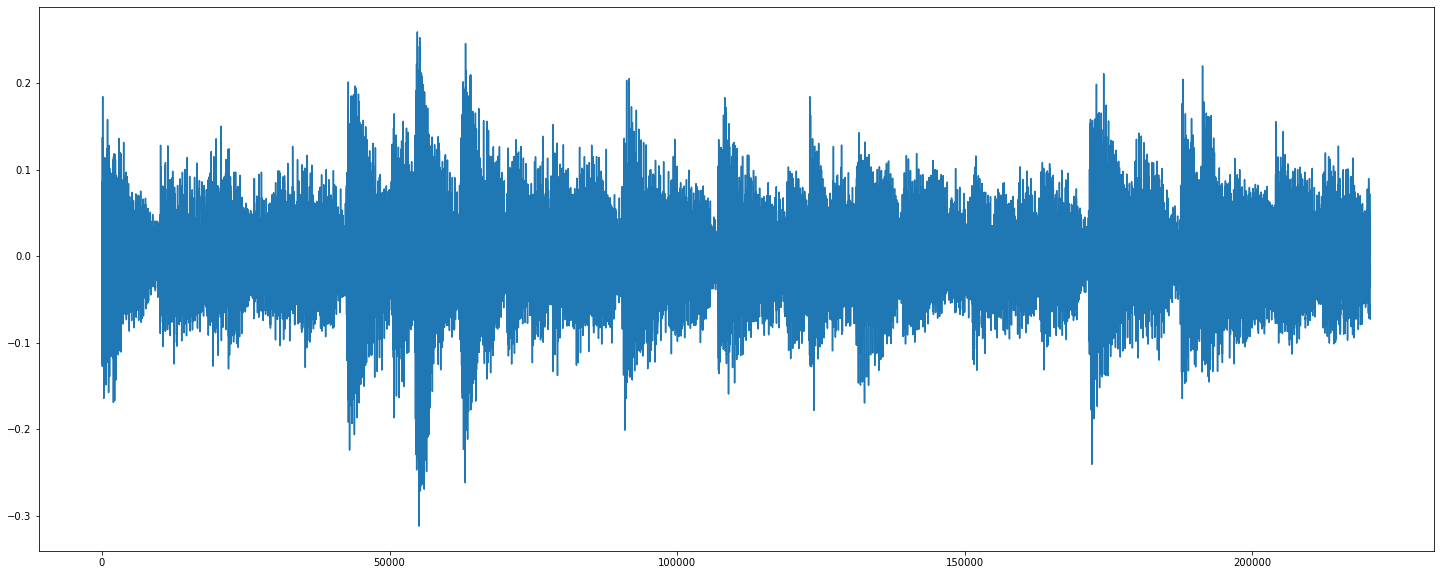

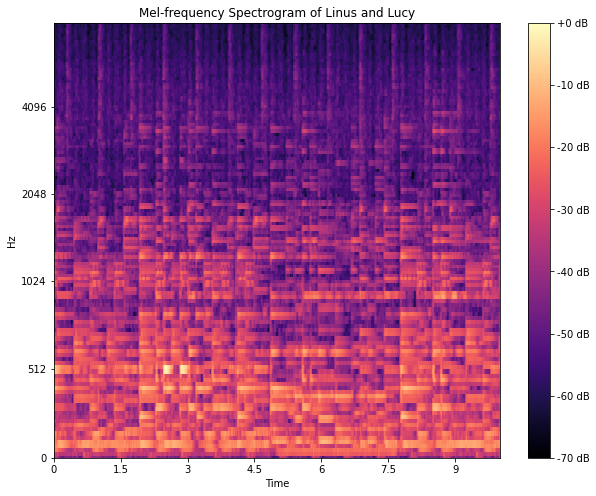

In [186]:
def get_audio(file, start, stop):
    '''
    parameters:
        file: str, location of audio filein mp3 audio file
        start: beggining of clip in seconds
        stop: end of clip in seconds
    returns:
        tuple
        data: numpy array
        sr: int
    '''
    fig, ax = plt.subplots(figsize = (25, 10))
    data, sr = librosa.load(file, mono=True)
    data = data[sr*start:sr*stop]
    ax.plot(data)
    return (data, sr)

def get_spec(lib_file, sr):
    cmap = plt.get_cmap('viridis')
#     plt.figure(figsize=(10,8))
#     plt.specgram(lib_file, NFFT=2048, Fs=2, Fc=0, 
#                  noverlap=128, cmap=cmap, 
#                  sides='default', mode='default',
#                  scale='dB');
    
#     spec = librosa.feature.melspectrogram(y=lib_file, sr=22050, 
#                                    S=None, n_fft=2048, 
#                                    hop_length=512, 
#                                    win_length=None, 
#                                    window='hann', 
#                                    center=True, 
#                                    pad_mode='reflect', 
#                                    power=2.0)
    
#     librosa.display.specshow(librosa.power_to_db(spec, ref=np.max))
    
#     plt.title('Spectrogram of the First Ten Seconds of Linus & Lucy')
#     plt.ylabel('Mel-Frequency')
#     plt.show()
#     plt.xticks(xticks=range(0, 11, 2), labels=range(0, int(len(data)/sr)))
#     plt.savefig(f'/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/linus_and_lucy.png')
#     plt.clf()
    
    # Passing through arguments to the Mel filters
    S = librosa.feature.melspectrogram(y=lib_file, sr=sr, n_mels=128,
                                        fmax=8000)
    fig, ax = plt.subplots(figsize = (10,8))
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency Spectrogram of Linus and Lucy')
    plt.savefig(f'/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/linus_and_lucy.png')

    
    
data, sr = get_audio('/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/linus_and_lucy.mp3', 0, 10) 
get_spec(data, sr)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

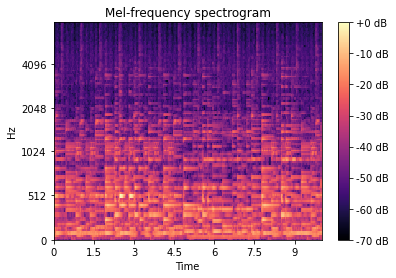

In [142]:
# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,
                                    fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

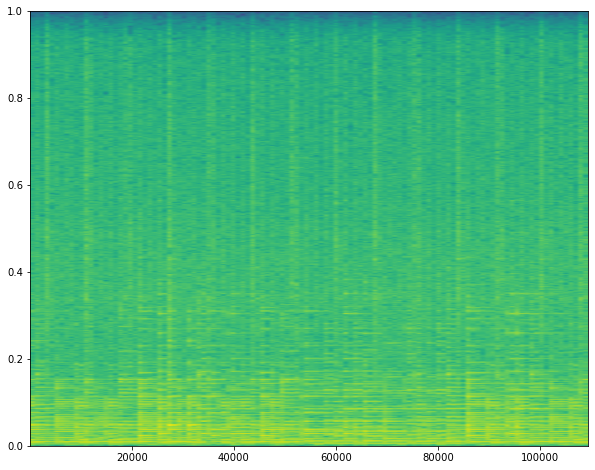

In [128]:
#ll
cmap = plt.get_cmap('viridis')
plt.figure(figsize=(10,8))
plt.specgram(data, NFFT=2048, Fs=2, Fc=0, 
             noverlap=128, cmap=cmap, 
             sides='default', mode='default', 
             scale='dB');
#plt.axis('off');

## Spectral centroids

In [154]:
x, sr = librosa.load(ll_path, mono=True)
x = x[sr*start:sr*stop]

In [155]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

(431,)

In [156]:
## time for visuals
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

In [158]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

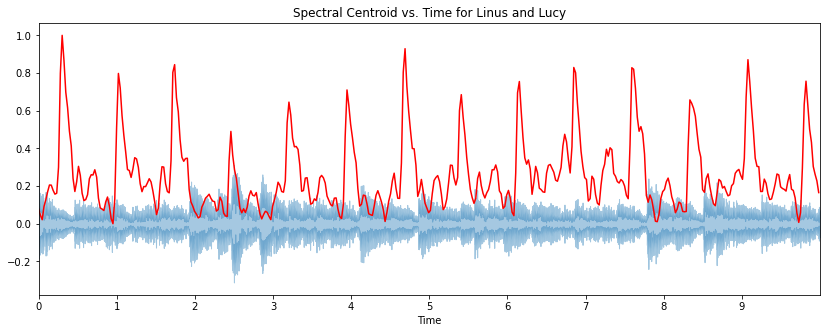

In [198]:
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.title('Spectral Centroid vs. Time for Linus and Lucy')
plt.savefig(f'/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/img/spectral_centroid.png')


## Spectral Bandwidth

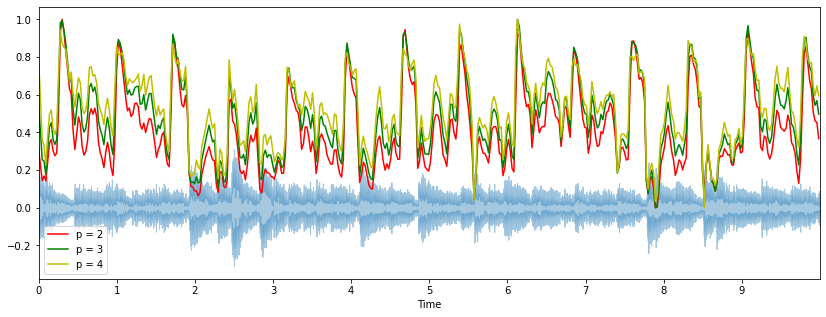

In [165]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))

## Zero Crossing Rate

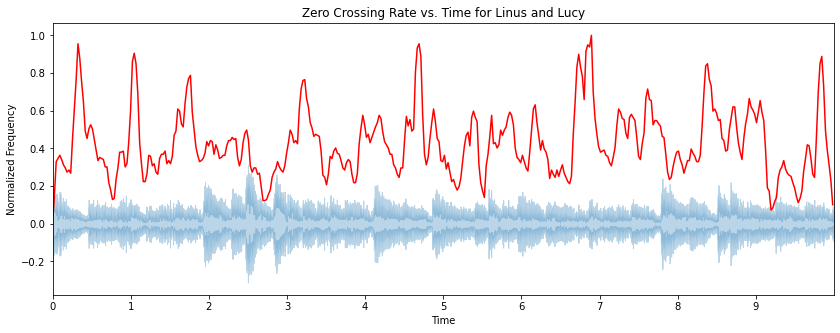

In [222]:
zcr = librosa.feature.zero_crossing_rate(x)
librosa.display.waveplot(x, sr=sr, alpha=0.3)
plt.title('Zero Crossing Rate vs. Time for Linus and Lucy')
plt.ylabel('Normalized Frequency')
plt.plot(t, normalize(zcr.T), color='r');
plt.savefig('/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/img/zcr.png')


In [212]:
t.shape, zcr.T.shape

((431,), (431, 1))

## Plotting spectral rolloff

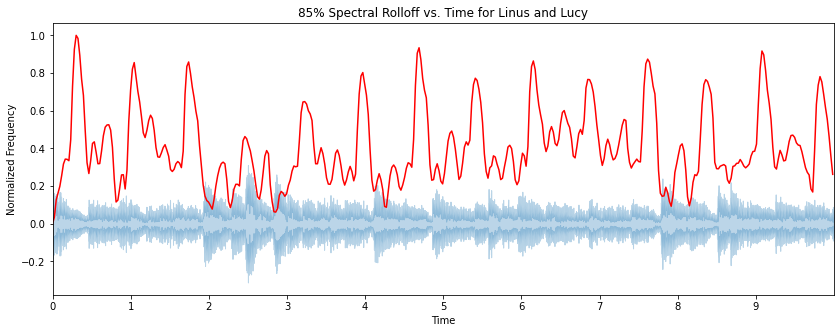

In [199]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr, n_fft=4000)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.3)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.ylabel('Normalized Frequency')
plt.title('85% Spectral Rolloff vs. Time for Linus and Lucy')
#plt.plot(x, sr=sr, alpha=0.3)
plt.savefig(f'/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/img/spectral_rolloff.png')
## The y-axis (Hz) is normalized, for reference these peaks are about 7000 hz, while the valleys are around 4000 hz.

## Chroma Frequencies

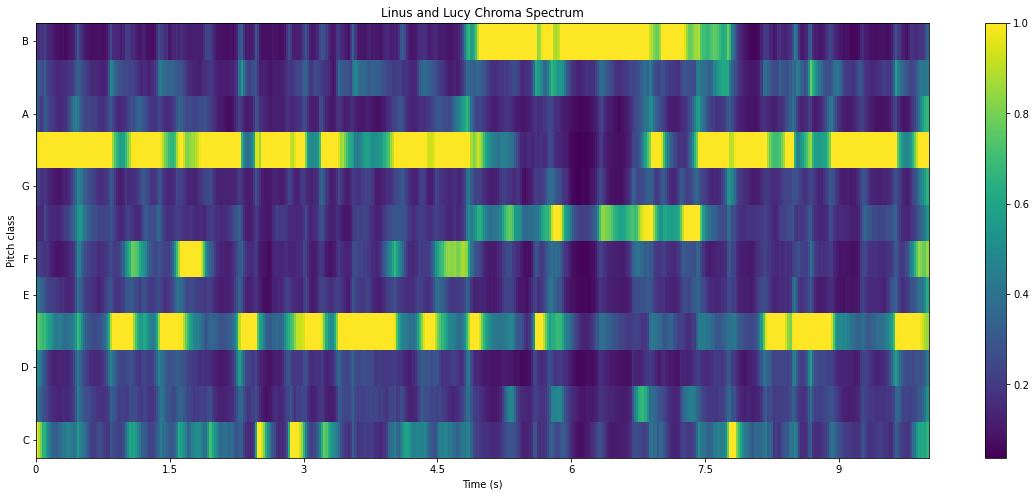

In [196]:
chroma = librosa.feature.chroma_cqt(y=x, sr=sr)
# librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
# plt.colorbar()
plt.figure(figsize=(20,8))
plt.title('Linus and Lucy Chroma Spectrum')
librosa.display.specshow(chroma, sr=sr, x_axis='s', y_axis='chroma', cmap='viridis')
plt.colorbar()
plt.savefig(f'/Users/joshbernd/Desktop/gal_notes/Capstone/CNN-Instrument-Classification/img/chroma_freq.png')


## 5. Extracting features from Spectrogram: 
1 - Mel-frequency cepstral coefficients (MFCC) 

2 - Spectral Centroid

3 - Zero Crossing Rate

4 - Chroma Frequencies

5 - Spectral Roll-off.

In [44]:
## dataset part 1
data_2SQxfaWAJJg = pd.read_csv('data_2SQxfaWAJJg.csv')

In [45]:
data_2SQxfaWAJJg.head()

,YTID,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,--PJHxphWEs,0.144023,0.054509,3083.525008,2727.951400,6136.962891,0.000488,-677.725464,-60.321907,-1.675254,...,13.621056,65.283966,22.037888,-34.077576,1.344032,20.719837,-14.135757,39.440418,57.690269,-45.903584
1,--aE2O5G5WE,0.146669,0.021313,2056.899989,3176.120465,4909.570312,0.000000,-777.996643,-49.890053,13.396999,...,19.317492,51.159569,19.382998,-14.735193,-7.327859,12.584110,6.626073,29.135651,46.241631,-31.901894
2,--aaILOrkII,0.139654,0.399394,480.337467,1242.651527,1227.392578,0.000000,-516.471558,-17.606678,-2.516232,...,17.650810,48.678459,19.960388,-8.039909,-14.162983,9.131400,13.745262,32.253983,34.012314,-23.337450
3,--ekDLDTUXA,0.138681,0.165942,1829.442944,2935.817842,4888.037109,0.000000,-582.247437,-39.230446,1.131112,...,22.324093,48.208324,36.402683,-29.619797,-3.743885,4.963671,13.029894,30.473604,50.506432,-39.929340
4,-0DLPzsiXXE,0.127109,0.105959,615.570322,1197.365486,1227.392578,0.000000,-648.820496,-10.084522,-14.630152,...,22.861109,58.259071,19.598347,-16.472555,-7.158563,1.041936,18.206760,29.127785,45.998291,-32.090473
